In [1]:
# This is always required for inline plot rendering in IPython Notebooks; might
# as well do it first, even before the markdown sections, just to be safe
#%matplotlib inline
%matplotlib notebook

# Adjusted Data Algorithm - Contents:

- [Theoretical Basis](#Theoretical-Basis)
  - [Motivation](#Motivation)
  - [Affine Transformations](#Affine-Transformations)
  - [Adaptive Coefficients](#Adaptive-Coefficients)
  - [Anomaly Detection](#Anomaly-Detection)
- [Putting it All Together](#Putting-it-All-Together)
  - [Programming Interface](#Programming-Interface)
- [Functional Tests](#Functional-Tests)
  - [Imports](#Imports)
  - [Test Configuration](#Test-Configuration)
  - [Test 1](#Test-1) | [Test 2](#Test-2) | [Test 3](#Test-3) | [Test 4](#Test-4) | [Test 5](#Test-5)  
- [Synthetic Data Demonstration](#Synthetic-Data-Demonstration)
  - [Construct synthetic time series](#Construct-synthetic-time-series)
  - [Estimate Affine Transformation Matrix](#Estimate-Affine-Transformation-Matrix)
- [Comparison with (Quasi-)Definitive Data](#Comparison-with-(Quasi-)Definitive-Data)
  - [Boulder (BOU) Observatory](#Boulder-(BOU)-Observatory)
  - [Barrow (BRW) Observatory](#Barrow-(BRW)-Observatory)
  - [Stennis (BSL) Observatory](#Stennis-(BSL)-Observatory)
  - [College (CMO) Observatory](#College-(CMO)-Observatory)
  - [Deadhorse (DED) Observatory](#Deadhorse-(DED)-Observatory)
  - [Fredericksburgh (FRD) Observatory](#Fredericksburgh-(FRD)-Observatory)
  - [Fresno (FRN) Observatory](#Fresno-(FRN)-Observatory)
  - [Guam (GUA) Observatory](#Guam-(GUA)-Observatory)
  - [Honolulu (HON) Observatory](#Honolulu-(HON)-Observatory)
  - [Newport (NEW) Observatory](#Newport-(NEW)-Observatory)
  - [San Juan (SJG) Observatory](#San-Juan-(SJG)-Observatory)
  - [Shumagin (SHU) Observatory](#Shumagin-(SHU)-Observatory)
  - [Sitka (SIT) Observatory](#Sitka-(SIT)-Observatory)
  - [Tucson (TUC) Observatory](#Tucson-(TUC)-Observatory)

# [Theoretical Basis](#Adjusted-Data-Algorithm---Contents:)

## [Motivation](#Adjusted-Data-Algorithm---Contents:)

The USGS employs 3-axis vector magnetometers, typically using fluxgate technology in the modern era. Alone, these magnetometers are high-quality variometers. That is, they record the relative variation of Earth's magnetic field over time very accurately, but are notoriously difficult to calibrate in an absolute sense. It is only when variometers are combined with frequent absolute calibration measurements that we get what is generally described as a **geomagnetic observatory**.

Historically, the merging of these absolute calibrations and magnetic variation measurements has been a laborious process, ultimately resulting in the magnetic observatory community's standard "definitive" data product for each obseratory. Definitive data is processed in one year blocks, starting no less than one year after the first observation made that year, and so not nearly a real time product. More recently, some of the most stringent requirements for definitive data were relaxed so that a new community standard, "quasi-definitive" data, could be produced in a more timely (~1 month delay), but this was still not real time enough for many modern technological applications.

There is a growing and still largely unmet demand for calibrated near real time data. Following INTERMAGNET terminology, we will refer to this as Adjusted Data, although it is also often referred to as "provisional" in the magnetic observatory community. The Adjusted Data standard is not strictly defined, but the goal stated in the newest version of INTERMAGNET's Technical Reference Manual is to match statistical specifications of quasi-definitive data, while acknowledging and accepting the fact that real time data is likely to be more noisy, and/or have more gaps.

There was a previous attempt to produce Adjusted Data at the USGS that went largely undocumented. Given subsequent staff turnover and decommissioning of legacy computer systems, it is now impossible to asses the quality of this prototype data product, or fully understand why it was never deployed operationally. We speculate, with some anecdotal evidence, that the algorithm for generating these data was only a minor adaptation of the definitive processing software, which we already know is not particularly suited to real time processing.

This report is an attempt to: 1) distill and document institutional knowledge associated with legacy procedures and software for generating (quasi-)definitive data, partly to 2) assess how or why these legacy procedures and software may have been inadequate for near real time adjusted data generation, and 3) desdcribe, demonstrate, and validate a new methodology that is specifically tailored for near real time processing.

## [Traditional Baseline Adjustments](#Adjusted-Data-Algorithm---Contents:)

Fluxgate sensors have a limited range over which their response functions can be considered linear. In order to maximize their sensitivity while still measuring the extremely wide range of magnetic environments encountered across Earth's surface, it is common practice to generate a bias magnetic field that opposes and (mostly) nullifies the Earth's main magnetic field along each of the instrument's axes. In doing so, the fluxgate can precisely capture minute relative variations in the magnetic field relative to the main field. One need only add the static oppositional field back to these variational measurements for an accurate and precise measure of the time-varying geomagnetic field.

While this oppositional magnetic field strength might be estimated from first principals, significant static and time-dependent uncertainties in the fluxgate's mechanical geometries, plus electronic/electrical inefficiencies, conspire to require frequent and regular calibration to meet tolerances expected of magnetic observatories. So frequent, in fact, that removing the sensors to a lab to do so is not generally advisable, so the sensors are effectively calibrated in-place using absolute measurements, along with various physical and geometric assumptions, to calculate so-called baseline adjustments.

Absolute measurements should not be made too closely to the fluxgate sensor, or there is risk of contaminating the data. Therefore, part of the baseline adjustment implicitly includes the quasi time-stationary vector difference between the fluxgate and absolute pier different locations. While this value could, in principal, be obtained through careful simultaneous absolute measurements at both locations, it is not really necessary unless one is genuinely interested in isolating the fluxgate's true response functions.

Also, alignment of the fluxgate and absolute measurement coordinate frames is never perfect. But, if they are close, misalignment can be corrected using simple baseline adjustments and implicit small angle assumptions. When coordinate frames are not well aligned an initial rotation may be applied to obtain nominal alignment, and allow simple baseline corrections after that.

The USGS, as well as many international magnetic observatories, install their fluxgate sensors so that the primary horizontal axis, $H$, aligns with the local magnetic meridian. This means that the secondary horizontal axis, $E$ (for eastward), need not nullify the Earth's main field in this direction since, on average, it will be zero. Also, it is assumed that the absolute-fluxgate pier difference is zero in the $E$ direction. There is undoubtedly additional uncertainty in the $E$ direction, but in practice, it is ignored in favor of rotating the $H$ axis by a declination baseline angle:

$$
D_{base} = D_{abs} - \arcsin(E/H_{abs})
$$

With the absolute and fluxgate coordinate axes now roughly aligned, the $H$ baseline correction is estimated by projecting the absolute horizontal intensity onto the fluxgate's $H$ axis, and subtracting the fluxgate-measured magnetic field:

$$
H_{base} = \sqrt{H_{abs}^2 - E^2} - H
$$

This is illustrated in the following figure, where the blue vector represents the absolute total horizontal magnetic vector in geographic coordinates, the red vector represents the horizontal vector measured by the fluxgate in its own Cartesian coordinates, the green items comprise baseline corrections, and the brown angle $D$ is the declination relative to the fluxgate's $H$ axis:

![Traditional Horizontal Baseline Correction](../images/HorizMagCorrectionTraditional.png)

Finally, the third axis, $Z$, points downward to complete a right-handed coordinate system. The downward absolute magnetic vector component, $Z_{abs}$, is assumed to align reasonably well with the downward fluxgate axis, $Z$, so a simple baseline correction is all that is needed:

$$
Z_{base} = Z_{abs} - Z
$$

We note, for completeness, that it is not uncommon for small angle approximations to be invoked when calculating $H_{base}$ or $D_{base}$, since for most observatories, the ratio of the $E$ to the $H_{abs}$ magnetic vector component is small. For example, even for Barrow, Alaska, small angle error is rarely more than a few parts in a million when the fluxgate in aligned with the local magnetic meridian. However, the local magnetic meridian drifts over time, more-so at higher latitudes than low. And at the magnetic pole, the concept of a magnetic meridian is undefined. If following traditional baseline correction procedures, it is best to avoid small angle approximations altogether.

## [Affine Transformations](#Adjusted-Data-Algorithm---Contents:)

One problem with traditional baseline adjustments is that they assume each axis is independent of the others when they are not in most real-world scenarios. Therefore, there are necessarily more than just 3 degrees of freedom to be adjusted. If one considers separately non-orthogonality of the instrument axes, scaling differences for each axis, rotation, and yes, actual baseline differences between the fluxgate sensor and the absolute measurement device, there are no fewer than 12 degrees of freedom that might be considered.

A more rigorous approach to adjusting raw magnetic vector data is to generate a linear transformation that directly converts variometer data from its own local Cartesian $HEZ$ sensor coordinates into absolutely calibrated Cartesian $XYZ$ geographic coordinates. Standard linear transformations involve rotation, scaling, and even shear (that is, non-rigid rotation), while alignment of coordinate frame origins (that is, translation) can be easily included with a simple augmentation of the measurement vectors. This is known as an affine transformation:

$$ \left[\begin{array}{cccc} X \\ 
                             Y \\
                             Z \\
                             1 \end{array}\right] = 
                             [\textbf{M}] \left[ \begin{array}{cccc} H \\ 
                                                                     E \\
                                                                     Z \\
                                                                     1 \end{array}\right] $$
                          
...where $\textbf{M}$ is the composition of potentially many separate affine transforms:

$$
\begin{array}{r@{}l}
[\textbf{M}] & = & \left[ \begin{array}{cccc}  1  &  0  &  0  & t_1 \\ 
                                      0  &  1  &  0  & t_2 \\
                                      0  &  0  &  1  & t_3 \\
                                      0  &  0  &  0  &  1 \end{array}\right] \cdotp \text{  (i.e., } \textbf{T}\text{)}\\
    &   & \left[ \left[ \begin{array}{cccc} 1 &      0       &       0       &  0 \\ 
                                     0 & \cos\theta_x & -\sin\theta_x &  0 \\
                                     0 & \sin\theta_x &  \cos\theta_x &  0 \\
                                     0 &      0       &       0       &  1 \end{array}\right] \cdotp
          \left[ \begin{array}{cccc} \cos\theta_y &    0  & \sin\theta_y &  0 \\ 
                                           0      &    1  &       0      &  0 \\
                                    -\sin\theta_y &    0  & \cos\theta_y &  0 \\
                                          0       &    0  &      0       &  1 \end{array}\right] \cdotp
          \left[ \begin{array}{cccc} \cos\theta_z & -\sin\theta_z &  0  &  0 \\ 
                                     \sin\theta_z &  \cos\theta_z &  0  &  0 \\
                                          0       &       0       &  1  &  0 \\
                                          0       &       0       &  0  &  1 \end{array}\right] \right] \cdotp \text{  (i.e., } \textbf{R}\text{)} \\
    &   & \left[ \begin{array}{cccc} s_1 &  0  &  0  &  0 \\ 
                                      0  & s_2 &  0  &  0 \\
                                      0  &  0  & s_3 &  0 \\
                                      0  &  0  &  0  &  1 \end{array}\right] \cdotp \text{  (i.e., } \textbf{S}\text{)} \\
    &   & \left[ \begin{array}{cccc}  1  &  h_{xy} &  h_{xz} &  0 \\ 
                                      0  &    1    &  h_{yz} &  0 \\
                                      0  &    0    &    1    &  0 \\
                                      0  &    0    &    0    &  1 \end{array}\right]  \text{  (i.e., } \textbf{H}\text{)}
\end{array}
$$

Note that order of operation is critical, but there is no single standard for composing a full affine transformation from its constituent matrices. The preceding example follows a norm used in the [Python Transforms3D](https://pypi.org/project/transforms3d/) package, that might better be represented algorithmically as $dot(\textbf{T}, dot(\textbf{R}, dot(\textbf{S},\textbf{H}) ) )$, where "$dot$" is a matrix dot product function. In words, a shear correction ($\textbf{H}$ is first applied to the original $HEZ$ vector to orthogonalize it. This is followed by rescaling the orthogonalized $HEZ$ vectors with $\textbf{S}$, which is followed by a rigid rotation $\textbf{R}$ to align all axes with the desired $XYZ$ coordinate frame. Finally, the origin of the now rotated, scaled, and orthogonal vector is translated to make the coordinate frame origins coincide using $\textbf{T}$.

Looking more closely at $\textbf{R} = dot(\textbf{R}_x, dot(\textbf{R}_y,\textbf{R}_z))$, it should be even more evident that order of operation is important. The rotation angles ($\theta_x$, $\theta_y$, and $\theta_z$) that combine to form $\textbf{R}$ are presented here in a manner that resembles typical yaw-pitch-roll rotations. This is 1 of 6 possible so-called Tait-Bryan rotation sequences (re-orientation by rotating around each unique axis once). Proper Euler angles have 6 additional possible sequences that involve a rotation about one axis, then a second, then again about the first. If that were not enough, both the Tait-Bryan and proper Euler angles can be with respect to fixed axes (extrinsic; as above), or with respect to the new axes after each rotation (intrinsic). This leads to 24 possible valid rotations! It is highly recommended that one convention is chosen and used consistently.

The astute reader may wonder at the particular form of $\textbf{H}$. It is certainly possible to allow shear coefficients in all the off-diagonal elements of the upper-left 3x3 matrix, but we choose not to here for at least two reasons: 

  1. shear, by definition, must not alter the volume of the original data points, or in mathematical terms, its determinant is always 1, which is guaranteed by this triangular form; and 
  2. this triangular form permits an efficient mechanism for separating rigid rotation from pure shear (see "Decomposing a matrix into simple transformations" by Spencer W. Thomas, pp 320-323 in *Graphics Gems II*, James Arvo (editor), Academic Press, 1991, ISBN: 0120644819).

A nuance related to item 2 is that the solution is only unique in so far as this structure is chosen for the shear. If a different structure is chosen, the rotation matrix will be different, even though the composition of shear and rotation will always be the same. In more practical terms, this means that it is not correct to speak of  "rotation" and "shear" separately, and certainly not appropriate to drop one without careful consideration. In particular, the structure chosen here (i.e., upper-triangular) means that the vector is rotated so that the $Z$ axis of both coordinate frames are aligned perfectly. Then the $E$ axis is sheared in the $Z$ direction, and the $H$ axis is sheared in both $Z$ and $E$ directions.

## [Estimating Affine Transform Matrix](#Adjusted-Data-Algorithm---Contents:)

While the constituent affine matrices can, in theory, be created individually, through careful sensor design and construction, laboratory calibration, and/or surveying of the observatory site, in practice these are not always possible or adequate. Ultimately, if absolute $XYZ$ measurements are considered the "truth" to which variational measurements are to be corrected, the linear structure of the affine transformation allows us to invoke linear estimation theory to determine an optimal transform matrix $\textbf{M}$ that encapsulates all the necessary corrections to the original $HEZ$ vector data.

$$ \left[\begin{array}{cccc} X_1 & X_2 & \ldots & X_n \\ 
                          Y_1 & Y_2 & \ldots & Y_n \\
                          Z_1 & Z_2 & \ldots & Z_n \\
                          1   &  1  &  \ldots & 1 \end{array}\right] = 
                          \left[ \begin{array}{cccc} M_{11} & M_{12} & M_{13} & M_{14} \\
                                                     M_{21} & M_{22} & M_{23} & M_{24} \\
                                                     M_{31} & M_{32} & M_{33} & M_{34} \\
                                                     M_{41} & M_{42} & M_{43} & M_{44} \end{array}\right]
                          \cdotp
                          \left[ \begin{array}{cccc} H_1 & H_2 & \ldots & H_n \\ 
                                                     E_1 & E_2 & \ldots & E_n \\
                                                     Z_1 & Z_2 & \ldots & Z_n \\
                                                     1   &  1  &  \ldots & 1 \end{array}\right] $$

### [Least Squares](#Adjusted-Data-Algorithm---Contents:)

The most straight-forward estimation technique is least-squares. Many mathematical software libraries have efficient routines that, given measurement arrays constructed similarly to above, will use linear least squares to determine an optimal 4x4 $\textbf{M}$ matrix to map $HEZ1$ into $XYZ1$ vectors. However, what these all inevitably do, at least under the hood, is rearrange the previous matrix equation algebraically such that:

$$ \left[\begin{array}{c} X_1 \\  
                          Y_1 \\
                          Z_1 \\
                           1 \\
                          X_2 \\  
                          Y_2 \\
                          Z_2 \\
                           1 \\
                          \vdots \\
                          X_n \\  
                          Y_n \\
                          Z_n \\ 
                           1 \end{array}\right] = 
                          \left[ \begin{array}{cccccccccccccccc}
                  H_1 & E_1 & Z_1 &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
                   0  &  0  &  0  &  0  & H_1 & E_1 & Z_1 &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
                   0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  & H_1 & E_1 & Z_1 &  1  &  0  &  0  &  0  &  0 \\
                   0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  & H_1 & E_1 & Z_1 &  1 \\
                  H_2 & E_2 & Z_2 &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
                   0  &  0  &  0  &  0  & H_2 & E_2 & Z_2 &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
                   0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  & H_2 & E_2 & Z_2 &  1  &  0  &  0  &  0  &  0 \\
                   0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  & H_2 & E_2 & Z_2 &  1 \\
                 \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & 
                 \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots &  \\ 
                  H_n & E_n & Z_n &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
                   0  &  0  &  0  &  0  & H_n & E_n & Z_n &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
                   0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  & H_n & E_n & Z_n &  1  &  0  &  0  &  0  &  0 \\
                   0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  & H_n & E_n & Z_n &  1 \\
                  \end{array} \right] \cdotp
                          \left[ \begin{array}{c}
                          M_{11} \\
                          M_{12} \\
                          M_{13} \\
                          M_{14} \\
                          M_{21} \\
                          M_{22} \\
                          M_{23} \\
                          M_{24} \\
                          M_{31} \\
                          M_{32} \\
                          M_{33} \\
                          M_{34} \\
                          M_{41} \\
                          M_{42} \\
                          M_{43} \\
                          M_{44}\end{array}\right] $$

This system of equations is equivalent to the previous matrix equation with a 4x4 $\textbf{M}$, but perhaps makes it more clear that we are solving a set of linear equations for 16 unknowns. Given that a single vector measurement comprises only three actual data points, plus the augmented "1", it should also be clear that no fewer than 4 sets of absolute and fluxgate measurements are required to obtain a solution. Preferably, there would be many more than 4 sets, thus reducing uncertainty associated with the solution.

It is often desirable to constrain the system of equations, usually to reduce the degrees of freedom and reduce the uncertainty associated with the solution to a given system of equations. In fact, while one of the biggest advantages to using affine transformations might be that they include scale factors and shear corrections, in addition to rotation and translation, it has been our experience that allowing so many free parameters leads to over-fitting of the training data. When this happens, the solution, $\textbf{M}$, does not generalize well when used to adjust raw data between absolute measurements. If the frequency of absolute measurements could be increased substantially, it might be sufficient to reduce uncertainty enough that realistic scale and shear calibrations could be obtained from absolute measurements. Until such time, limiting the number of degrees of freedom helps avoid over-fitting the limited absolute training data.

We recommend doing so in a manner somewhat consistent with traditional (quasi)definitive processing. To start, if we look closely at all the transform matrices in the previous subsection, it is evident that the final row of $\textbf{M}$ should always be $\left[\begin{array}{cccc} 0 & 0 & 0 & 1 \end{array} \right]$. We can exploit this knowledge to remove the $M_{4*}$ unknowns from our system of equations, and their corresponding columns in the measurement matrices, thus reducing our number of unknowns from 16 to 12, and slightly reducing uncertainty in the remaining estimated coefficients.

$$ \left[\begin{array}{c} X_1 \\  
                          Y_1 \\
                          Z_1 \\
                          X_2 \\  
                          Y_2 \\
                          Z_2 \\
                          \vdots \\
                          X_n \\  
                          Y_n \\
                          Z_n \end{array}\right] = 
                          \left[ \begin{array}{cccccccccccccccc}
                  H_1 & E_1 & Z_1 &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  \\
                   0  &  0  &  0  &  0  & H_1 & E_1 & Z_1 &  1  &  0  &  0  &  0  &  0 \\
                   0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  & H_1 & E_1 & Z_1 &  1 \\
                  H_2 & E_2 & Z_2 &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
                   0  &  0  &  0  &  0  & H_2 & E_2 & Z_2 &  1  &  0  &  0  &  0  &  0 \\
                   0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  & H_2 & E_2 & Z_2 &  1 \\
                 \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & 
                 \vdots & \vdots & \vdots & \vdots & \vdots & \vdots &  \\ 
                  H_n & E_n & Z_n &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
                   0  &  0  &  0  &  0  & H_n & E_n & Z_n &  1  &  0  &  0  &  0  &  0 \\
                   0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  & H_n & E_n & Z_n &  1 \\
                  \end{array} \right] \cdotp
                          \left[ \begin{array}{c}
                          M_{11} \\
                          M_{12} \\
                          M_{13} \\
                          M_{14} \\
                          M_{21} \\
                          M_{22} \\
                          M_{23} \\
                          M_{24} \\
                          M_{31} \\
                          M_{32} \\
                          M_{33} \\
                          M_{34} \end{array}\right] $$

This simple constraint does not buy us much. But now suppose we wish to reduce the the number of free parameters even further by imposing additional prior knowledge/assumptions on the structure of our matrix that are (mostly) consistent with traditional definitive processing techniques. For example, assume that 1) the vertical vector component $Z$ is perfectly aligned between the variometer and the absolute instrument, and 2) it is perfectly orthogonal to the horizontal components; also, 3) the transform of the horizontal vector component is a scaled rotation about the $Z$ axis (that is, no skew). Finally, 4) don't allow any translation of the horizontal components, and 5) only allow translation of the vertical component. This is accomplished by removing and/or moving elements of the previous matrix equation to give the following:

$$ \left[\begin{array}{c} X_1 \\  
                          Y_1 \\
                          (Z-Z)_1 \\
                          X_2 \\  
                          Y_2 \\
                          (Z-Z)_2 \\
                          \vdots \\
                          X_n \\  
                          Y_n \\
                          (Z-Z)_n \end{array}\right] = 
                          \left[ \begin{array}{cccccccccc}
                          H_1 & E_1 & \color{red}{[]}  &  \color{red}{[]}   &  \color{red}{[]}  &  \color{red}{[]}  &  \color{red}{[]}  &  \color{red}{[]}   &  \color{red}{[]}   &  \color{red}{[]}   &  \color{red}{[]}   &  0 \\
                          \color{green}{E_1} &  \color{green}{-H_1}  &  \color{red}{[]}   &  \color{red}{[]}   & \color{red}{[]} &  \color{red}{[]}  & \color{red}{[]}  &  \color{red}{[]}   &  \color{red}{[]}   &  \color{red}{[]}   &  \color{red}{[]}   &  0 \\
                          0 &  0  &  \color{red}{[]}   &  \color{red}{[]}   &  \color{red}{[]}  &  \color{red}{[]}  &  \color{red}{[]}   &  \color{red}{[]}   & \color{red}{[]}  & \color{red}{[]}  & \color{red}{[]}  &  1 \\
                          H_2 & E_2 & \color{red}{[]}  &  \color{red}{[]}   &  \color{red}{[]}  &  \color{red}{[]}  & \color{red}{[]}   &  \color{red}{[]}   &  \color{red}{[]}   &  \color{red}{[]}   &  \color{red}{[]}   &  0 \\
                          \color{green}{E_2} &  \color{green}{-H_2}  &  \color{red}{[]}   &  \color{red}{[]}   & \color{red}{[]} &  \color{red}{[]}  & \color{red}{[]}  &  \color{red}{[]}   &  \color{red}{[]}   &  \color{red}{[]}   &  \color{red}{[]}   &  0 \\
                           0 &  0  &  \color{red}{[]}   &  \color{red}{[]}   &  \color{red}{[]}  &  \color{red}{[]}  & \color{red}{[]}   &  \color{red}{[]}   & \color{red}{[]}  & \color{red}{[]}   & \color{red}{[]}  &  1 \\
              \vdots & \vdots & \color{red}{[]}  & \color{red}{[]}  & \color{red}{[]} & \color{red}{[]}   & \color{red}{[]}  & \color{red}{[]}  & \color{red}{[]}  & \color{red}{[]}  & \color{red}{[]}  & \vdots \\ 
                          H_n & E_n & \color{red}{[]}  &  \color{red}{[]}   &  \color{red}{[]}  &  \color{red}{[]}  &  \color{red}{[]}   &  \color{red}{[]}   &  \color{red}{[]}    &  \color{red}{[]}   &  \color{red}{[]}   &  0 \\
                          \color{green}{E_n} &  \color{green}{-H_n}  &  \color{red}{[]}   &  \color{red}{[]}   & \color{red}{[]} &  \color{red}{[]}  & \color{red}{[]}  &  \color{red}{[]}   &  \color{red}{[]}   &  \color{red}{[]}   &  \color{red}{[]}   &  0 \\
                          0  &  0  &  \color{red}{[]}   &  \color{red}{[]}   &  \color{red}{[]}  &  \color{red}{[]}  &  \color{red}{[]}   &  \color{red}{[]}   & \color{red}{[]}  & \color{red}{[]}  & \color{red}{[]}  &  1 \\
                          \end{array} \right] \cdotp
                          \left[ \begin{array}{c}
                          M_{11} \\
                          M_{12} \\
                          \color{red}{[]} \\
                          \color{red}{[]} \\
                          \color{red}{[]} \\
                          \color{red}{[]} \\
                          \color{red}{[]} \\
                          \color{red}{[]} \\
                          \color{red}{[]} \\
                          \color{red}{[]} \\
                          \color{red}{[]} \\
                          M_{34} \end{array}\right] $$

Here, green indicates moved/edited elements, while red brackets indicate where whole columns were removed, which in turn corresponds to a removal of one of the $M$ coefficients. It is now clear that the degrees of freedom have been reduced from 16 to just 3. Once this set of equations is solved for its three unknowns, they can be inserted into the corresponding locations in the $\textbf{M}$ matrix:

$$\textbf{M} = 
                          \left[ \begin{array}{cccc} M_{11}  & M_{12} &  0  &   0    \\
                                                     -M_{12} & M_{11} &  0  &   0    \\
                                                        0    &   0    &  1  & M_{34} \\
                                                        0    &   0    &  0  & 1 \end{array}\right] $$

### [Singular Value Decomposition](#Adjusted-Data-Algorithm---Contents:)

We note at this point that solving this reduced set of equations is not exactly equivalent to traditional (quasi)definitive processing as presented earlier. In fact, such an affine transform would look something like:

$$\textbf{M} = 
                          \left[ \begin{array}{cccc} \cos\theta_z & -\sin\theta_z &  0  & T_X \\ 
                                                     \sin\theta_z &  \cos\theta_z &  0  & T_Y    \\
                                                          0       &      0        &  1  & T_Z \\
                                                          0       &      0       &  0  & 1 \end{array}\right] $$

...where $T_X$ and $T_Y$ are $H_{base}$ rotated into the absolute $XY$ frame through $D_{base}$, or as presented here, $\theta_z$. But such a matrix cannot be solved for directly from the measurement matrices via least-squares. All is not lost, however. $\theta_z$ can be found by invoking singular value decomposition (SVD) to obtain the eigenvectors that define an orthonormal rotation matrix between two vector spaces.

With modern numerical libraries, this is actually relatively simple. First, remove the means from both the $HE$ and $XY$ measurement matrices so that their origins coincide (ignore $Z$ for now):

$$
    H_i' = H_i - \overline{H}, \quad E_i' = E_i - \overline{E} \\
    X_i' = X_i - \overline{X}, \quad Y_i' = Y_i - \overline{Y}
$$

Next, create a cross-covariance matrix between $HE$ and $XY$:

$$
    \textbf{C} = \left[ \begin{array}{cc} c_{11} & c_{12} \\
                                          c_{21} & c_{22} \end{array}\right]
$$

...where...

$$
    c_{11} = \sum_i^n H_i' X_i', \quad
    c_{12} = \sum_i^n H_i' Y_i', \quad
    c_{21} = \sum_i^n E_i' X_i', \quad
    c_{22} = \sum_i^n E_i' Y_i'
$$

Next, decompose $\textbf{C}$ into its singular values, plus left and right eigenvectors using the SVD routine found in your favorite numerical linear algebra library:

$$
    \textbf{C} = \textbf{USV}^*
$$

...where singular values $s_i$ comprise the diagonal elements of $\textbf{S}$, and the orthonormal matrices $\textbf{U}$ and $\textbf{V}^*$ can be combined to give the unscaled rotation that aligns $HE$ with $XY$:

$$
    \textbf{R} = \textbf{V}^{*\intercal} \cdotp \textbf{U}^\intercal
$$

Finally, with $\textbf{R}$, simply rotate $\overline{H}$ and $\overline{E}$ into absolute coordinates to obtain $T_X$ and $T_Y$:

$$
    \left[ \begin{array}{c} T_X \\
                            T_Y \end{array} \right] = 
    \textbf{R} \cdotp \left[ \begin{array}{c} \overline{H} \\
                                              \overline{E} \end{array} \right]
$$

($T_Z$ is simply the difference in the averages of the vertical components, just as with traditional processing)

Notice that there are now four degrees of freedom ($\theta_z$, $T_X$, $T_Y$, and $T_Z$) instead of the three traditional (quasi)definitive baselines. This is because $T_X$ and $T_Y$ are allowed to float, rather than be trigonometrically locked to one another via $\theta_z$. We might effectively do this with an affine transformation, and obtain a near perfect analog to (quasi)definitive processing, but one of the main problems with the traditional approach presented above is that it requires that the fluxgate sensor be aligned with the local magnetic meridian for the math/geometry to work out. Using affine transformations, this is no longer necessary. Of course by increasing the degrees of freedom, the uncertainty of our final solution is slightly higher; but then the uncertainty *should be* higher, since a potential offset in $E$ is now included in the calculations.

## [Adaptive Coefficients](#Adjusted-Data-Algorithm---Contents:)

ddd

# [Functional Tests](#SqDist-Algorithm---Contents:)

The purpose of this section is to demonstrate that the algorithm works as expected, and to a lesser extent, demonstrate its utility with realistic usage examples. While some material here might be extracted to generate unit tests for the algorithm, these are primarily *functional* tests, and may be more complex than one might want to incorporate into an automated testing framework. Explanatory markdown, inline comments, or both, should tie different tests to the Algorithm Theoretical Basis above as much as possible.

## [Imports](#SqDist-Algorithm---Contents:)

In [2]:
# standard Python libraries
import matplotlib as mpl
#import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.linalg as spl
import glob
from datetime import datetime 
import re
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from openpyxl import load_workbook

# 3rd-party libraries
import obspy
from obspy.core import UTCDateTime
import geomagio
from geomagio.edge import EdgeFactory
#from geomagio.Algorithm import DeltaFAlgorithm

## [Test Configuration](#SqDist-Algorithm---Contents:)

In [3]:
# define assert_almost_equal
assert_almost_equal = np.testing.assert_almost_equal

# define factory for retrieving raw observations
# NOTE: need to make sure QD data is on cwbpub before public release
#factory = EdgeFactory(host='cwbpub.cr.usgs.gov', port=2060)
factory = EdgeFactory(host='igskcicgvmmage2.cr.usgs.gov', port=2060)

# [Synthetic Data Demonstration](#Adjusted-Data-Algorithm---Contents:)

## [Construct synthetic time series](#Adjusted-Data-Algorithm---Contents:)

- define a regular series of times t, and synthetic "truth" vectors (x, y, z) that represent the desired results
- define an affine transformation matrix that converts the truth vectors into a different "observed" basis

<IPython.core.display.Javascript object>


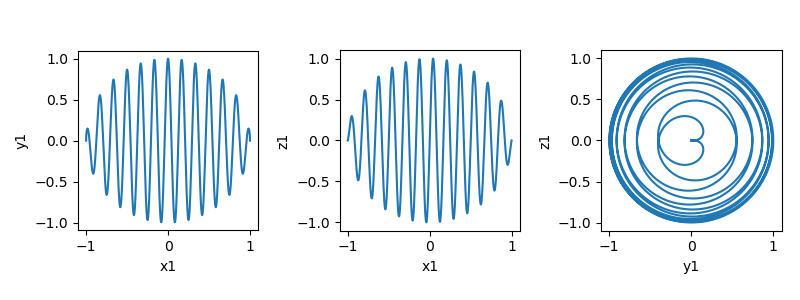

In [4]:
t = np.linspace(0, np.pi, 5000)

x1 = (2*t - np.pi)/np.pi
y1 = np.sqrt(1 - x1**2)*np.cos(24*t)
z1 = np.sqrt(1 - x1**2)*np.sin(24*t)

# plot xy plane, xz plane, and yz plane
plt.figure(figsize=(8,3))

plt.subplot(131)
plt.plot(x1,y1)
plt.xlabel('x1')
plt.ylabel('y1')
plt.gca().set_aspect('equal')

plt.subplot(132)
plt.plot(x1,z1)
plt.xlabel('x1')
plt.ylabel('z1')
plt.gca().set_aspect('equal')

plt.subplot(133)
plt.plot(y1,z1)
plt.xlabel('y1')
plt.ylabel('z1')
plt.gca().set_aspect('equal')

plt.tight_layout()

<IPython.core.display.Javascript object>


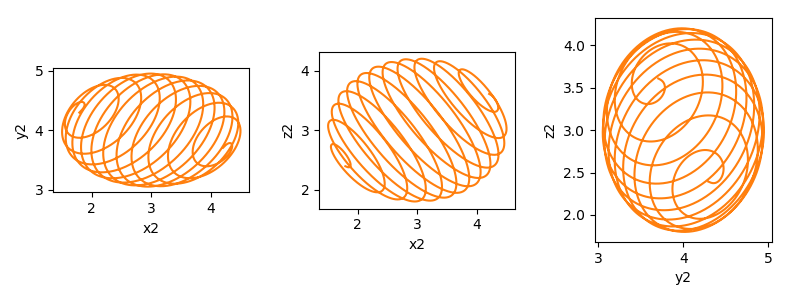

In [5]:
# first, create a pure rotation matrix
def make_axis_rotation_matrix(direction, angle):
     """
     Create a rotation matrix corresponding to the rotation around a general
     axis by a specified angle.
       R = dd^T + cos(a) (I - dd^T) + sin(a) skew(d)
     Parameters:
         angle : float a
         direction : array d
     """
     d = np.array(direction, dtype=np.float64)
     d /= np.linalg.norm(d)

     eye = np.eye(3, dtype=np.float64)
     ddt = np.outer(d, d)
     skew = np.array([[    0,  d[2],  -d[1]],
                      [-d[2],     0,  d[0]],
                      [d[1], -d[0],    0]], dtype=np.float64)

     mtx = ddt + np.cos(angle) * (eye - ddt) + np.sin(angle) * skew
     return mtx
Mrot = make_axis_rotation_matrix(np.array([1,1,1]),45*np.pi/180)

# second, create a pure scaling matrix
Mscale = np.array([[1.5, 0, 0], [0, 0.95, 0], [0, 0, 1.2]])

# third, create a pure translation vector
Vtrans = np.array([[3],[4],[3]])

# fourth, combine these into an affine transformation to our new basis
Maugmented = np.hstack([np.dot(Mscale,Mrot), Vtrans])
Maffine = np.vstack([Maugmented, np.array([0,0,0,1])])

# finally, apply this affine transformation to our "truth" data, extended by
# a time series of 1s for the translation
x2, y2, z2, _ = np.dot(Maffine, np.vstack((x1, y1, z1, np.ones_like(x1))))


# plot xy plane, xz plane, and yz plane
plt.figure(figsize=(8,3))

plt.subplot(131)
plt.plot(x2,y2*np.nan) # to force 2nd color
plt.plot(x2,y2)
plt.xlabel('x2')
plt.ylabel('y2')
plt.gca().set_aspect('equal')

plt.subplot(132)
plt.plot(x2,z2*np.nan) # to force 2nd color
plt.plot(x2,z2)
plt.xlabel('x2')
plt.ylabel('z2')
plt.gca().set_aspect('equal')

plt.subplot(133)
plt.plot(y2,z2*np.nan) # to force 2nd color
plt.plot(y2,z2)
plt.xlabel('y2')
plt.ylabel('z2')
plt.gca().set_aspect('equal')

plt.tight_layout()

<IPython.core.display.Javascript object>


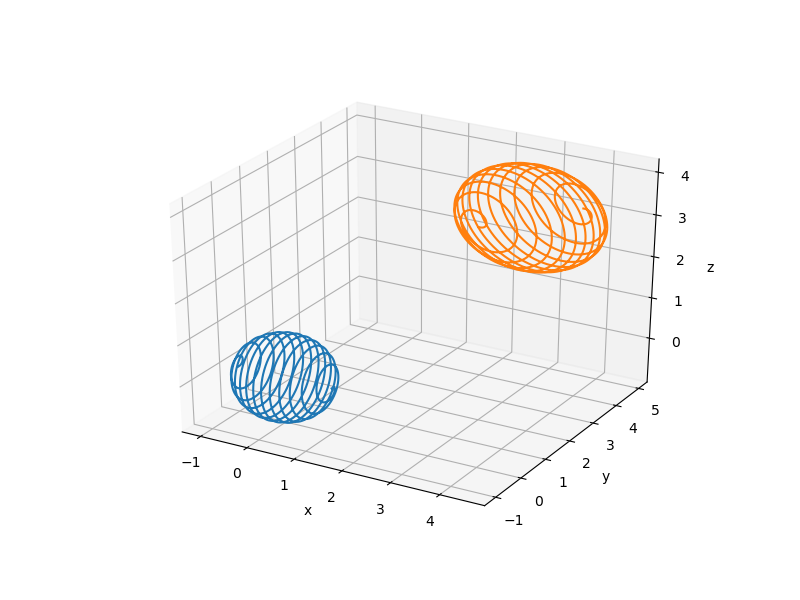

Text(0.5,0,'z')

In [6]:
# plot 3D view of 'truth' and transformed vectors
plt.figure(figsize=(8,6))

plt.subplot(111, projection='3d')
plt.plot(x1, y1, z1)
plt.plot(x2, y2, z2)
plt.gca().set_xlabel('x')
plt.gca().set_ylabel('y')
plt.gca().set_zlabel('z')

<IPython.core.display.Javascript object>


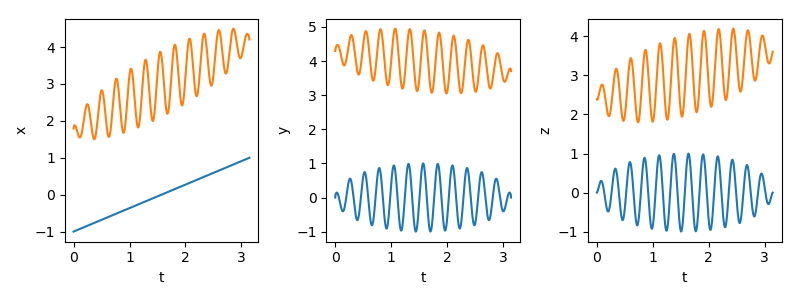

In [7]:
# plot vs time
plt.figure(figsize=(8,3))

plt.subplot(131)
plt.plot(t, x1)
plt.plot(t, x2)
plt.xlabel('t')
plt.ylabel('x')

plt.subplot(132)
plt.plot(t, y1)
plt.plot(t, y2)
plt.xlabel('t')
plt.ylabel('y')

plt.subplot(133)
plt.plot(t, z1)
plt.plot(t, z2)
plt.xlabel('t')
plt.ylabel('z')

plt.tight_layout()

## [Estimate Affine Transformation Matrix](#Adjusted-Data-Algorithm---Contents:)

Define functions to solve for the affine transform matrix $[M]$, and perform the transformation once $[M]$ is calculated.

$$ \left[\begin{array}{cccc} X_1 & X_2 & \ldots & X_n \\ 
                          Y_1 & Y_2 & \ldots & Y_n \\
                          Z_1 & Z_2 & \ldots & Z_n \\
                          1   &  1  &  \ldots & 1 \end{array}\right] = [M] \left[ \begin{array}{cccc} h_1 & h_2 & \ldots & h_n \\ 
                          e_1 & e_2 & \ldots & e_n \\
                          z_1 & z_2 & \ldots & z_n \\
                          1   &  1  &  \ldots & 1 \end{array}\right] $$

Below, we:
- sample "truth" observations (similar to taking "absolute" measurements)
- sample transformed observations (similar to variation measurements)
- invert for optimal affine trasnformation matrix M
- use M to calculate adjusted data
- plot observed and adjusted data

In [9]:
def get_transform_from_abs_ords(xyz_abs, hez_ord):
    '''
    pass two 3-row arrays (or 3-lists of vectors), one for each of:
    - absolute magnetic vectors in geographic frame (XYZ)
    - observed magnetic vectors in instrument frame (HEZ)
    
    Returns:
    - affine transform matrix to convert observed vectors to absolute basis
    - sum of residues from linear fit
    - effective rank of affine matrix
    - singular values
    '''
    tol = 1e-15
    
    ones = np.ones(hez_ord[0].shape)

    ordp2 = np.vstack([hez_ord,ones])

    absp2 = np.vstack([xyz_abs,ones])

    M, res, rank, sigma = np.linalg.lstsq(ordp2.T, absp2.T)

    maskM = np.abs(M) > tol
    M = maskM * M
        
    return M.T, res, rank, sigma


def make_adjusted_from_transform_and_raw(M, hez_ord):
    '''
    pass in:
    - affine transform matrix M
    - observed vectors as 3-row matrix (or 3-list of 1D arrays)
    
    Returns adjusted data in absolute geographic reference frame
    '''

    adj = np.dot(M, np.vstack([hez_ord, np.ones_like(hez_ord[0])]))

    return adj[0:3]

/Users/erigler/anaconda3/envs/test_GIMP_py36/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


<IPython.core.display.Javascript object>


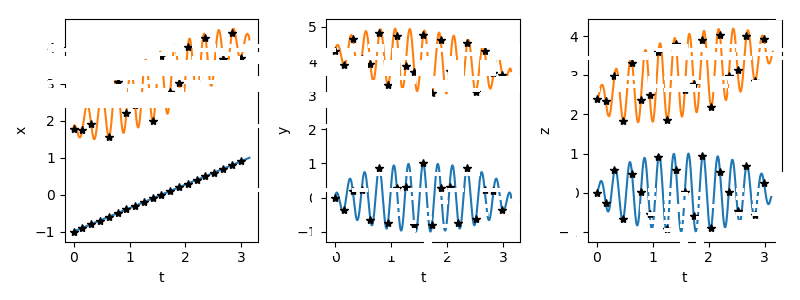

In [10]:
# sub-sample indices used to solve for M
idx_abs = np.arange(x1.size)[::250]

# solve for affine transforation matrix
M, resid, rank, lamda = get_transform_from_abs_ords([x1, y1, z1], [x2, y2, z2])

# calculate adjusted data
xadj, yadj, zadj = make_adjusted_from_transform_and_raw(M, [x2, y2, z2])

# plot sub-sampled observations and adjusted data (should look like plots above)
plt.figure(figsize=(8,3))

plt.subplot(131)
plt.plot(t, xadj)
plt.plot(t, x2)
plt.plot(t[idx_abs], x1[idx_abs],'*k')
plt.plot(t[idx_abs], x2[idx_abs],'*k')
plt.xlabel('t')
plt.ylabel('x')

plt.subplot(132)
plt.plot(t, yadj)
plt.plot(t, y2)
plt.plot(t[idx_abs], y1[idx_abs],'*k')
plt.plot(t[idx_abs], y2[idx_abs],'*k')
plt.xlabel('t')
plt.ylabel('y')

plt.subplot(133)
plt.plot(t, zadj)
plt.plot(t, z2)
plt.plot(t[idx_abs], z1[idx_abs],'*k')
plt.plot(t[idx_abs], z2[idx_abs],'*k')
plt.xlabel('t')
plt.ylabel('z')

plt.tight_layout()



# [Comparison with (Quasi-)Definitive Data](#Adjusted-Data-Algorithm---Contents:)

## Notebook Functions

### Baseline and Absolute Data Retrieval

Functions here should retrieve baseline and absolutes measurements:

**Inputs**  
```
obs_code     - 3-character IAGA code for observatory
start_date   - UTCDatetime for start of interval
end_date     - UTCDatetime for end of interval            
```
**Options**  
```
path_or_url  - string that holds a base path or url at which to
               find baseline and absolute observations
               (default = max(times))
```
**Output**  
```
h_abs_bas_utc - array holding vectors of h_abs, h_bas, and h_utc
d_abs_bas_utc - array holding vectors of d_abs, d_bas, and d_utc
z_abs_bas_utc - array holding vectors of z_abs, z_bas, and z_utc
pc            - array holding pier corrections

```

In [11]:
def retrieve_baselines_resid_summary_xlsm(obs_code, start_date, end_date,
                                          path_or_url = './'):
    '''
    Retrieve baselines from USGS Geomag residual method summary Excel 
    spreadsheets on local file system. This is a very simple data reader
    that assumes a fixed filename convention, and a fixed template for
    the summary spreadsheet.
    
    Inputs:
    obs_code    - 3-character IAGA code for observatory
    start_date  - UTCDatetime for start of interval
    end_date    - UTCDatetime for end of interval
    path_or_url - folder in which to find .xlsm files
    
    Outout:
    h_abs_bas_utc - array holding vectors of h_abs, h_bas, and h_utc
    d_abs_bas_utc - array holding vectors of d_abs, d_bas, and d_utc
    z_abs_bas_utc - array holding vectors of z_abs, z_bas, and z_utc
    pc            - array holding pier corrections
    '''
    #from glob import glob
    import os
    import fnmatch
    from openpyxl import load_workbook
    from datetime import timedelta
    from obspy.core import UTCDateTime
    
    # some default inputs
    if end_date is None:
        end_date = UTCDateTime.now()
    
    if start_date is None:
        start_date = UTCDatetime(0)
    
    
    # initialize outputs
    h_abs = []
    h_bas = []
    h_dt = []
    
    d_abs = []
    d_bas = []
    d_dt = []
    
    z_abs = []
    z_bas = []
    z_dt = []
    
    pc = []
    
    # openpyxl uses Python datetime objects
    start_dt = start_date.datetime
    end_dt = end_date.datetime
    last_dt = start_dt
    
    # loop over all [obs_code]??????????.xlsm files in all folders under path_or_url
    for root, dirnames, filenames in os.walk(path_or_url + '/' + obs_code.upper()):
        for filename in fnmatch.filter(filenames, obs_code.upper() + '???????????.xlsm'):
            
            # load workbook
            # (data_only=True forces openpyxl to read in data saved in
            #  a cell, even if the cell is actually a formula; if False,
            #  openpyxl would return the formuala; openpyxl NEVER evaluates
            #  a formula, it relies on values generated and cached by the
            #  spreadsheet program itself)
            wb = load_workbook(os.path.join(root,filename), data_only=True)

            # get worksheet 1
            ws1 = wb["Sheet1"]

            # get date (pyxl retrieves as datetime object)
            date = ws1["I1"].value
            
            # these spreadsheet files must have a particular layout; if there is
            # any problem reading in data, just skip the whole file
            try:
            
                # (re)initialize valid list
                valid = [True, True, True, True]

                # get and convert declination times
                d_time_str = ['%04i'%ws1["B10"].value,
                              '%04i'%ws1["B11"].value,
                              '%04i'%ws1["B12"].value,
                              '%04i'%ws1["B13"].value]
                d_time_delta = [timedelta(hours=int(s[0:2])) +
                                timedelta(minutes=int(s[2:4]))
                                for s in d_time_str]
                d_datetime = [date + td for td in d_time_delta]

                # get and convert declination absolute fractional angles
                d_absolute = [[float(ws1["C10"].value), float(ws1["D10"].value)],
                              [float(ws1["C11"].value), float(ws1["D11"].value)],
                              [float(ws1["C12"].value), float(ws1["D12"].value)],
                              [float(ws1["C13"].value), float(ws1["D13"].value)]]
                d_absolute = [d + m/60 for d,m in d_absolute if m is not None]

                # get and convert declination baseline fractional angles
                d_baseline = [float(ws1["H10"].value),
                              float(ws1["H11"].value),
                              float(ws1["H12"].value),
                              float(ws1["H13"].value)]
                d_baseline = [db/60 for db in d_baseline if db is not None]

                d_reject = [ws1["J10"].value,
                            ws1["J11"].value,
                            ws1["J12"].value,
                            ws1["J13"].value]

                # (relies on strings evaluating True, and Nones evaluating False)
                valid = [v and da is not None and db is not None and not dr
                         for v,da,db,dr in zip(valid, d_absolute, d_baseline, d_reject)]
                
                # get horizontal field times (for consistency with WebAbsolutes, even
                #  if these spreadsheets always have the same times for D, H, and Z)
                h_time_str = ['%04i'%ws1["B24"].value,
                              '%04i'%ws1["B25"].value,
                              '%04i'%ws1["B26"].value,
                              '%04i'%ws1["B27"].value]
                h_time_delta = [timedelta(hours=int(s[0:2])) +
                                timedelta(minutes=int(s[2:4]))
                                for s in h_time_str]
                h_datetime = [date + td for td in h_time_delta]

                # get absolute horizontal field magnitude in nT
                h_absolute = [float(ws1["D24"].value),
                              float(ws1["D25"].value),
                              float(ws1["D26"].value),
                              float(ws1["D27"].value)]

                # get baseline horizontal field magnitude in nT
                h_baseline = [float(ws1["H24"].value),
                              float(ws1["H25"].value),
                              float(ws1["H26"].value),
                              float(ws1["H27"].value)]

                h_reject = [ws1["J24"].value,
                            ws1["J25"].value,
                            ws1["J26"].value,
                            ws1["J27"].value]

                # (relies on strings evaluating True, and Nones evaluating False)
                valid = [v and ha is not None and hb is not None and not hr
                         for v,ha,hb,hr in zip(valid, h_absolute, h_baseline, h_reject)] 


                # get vertical field times (for consistency with WebAbsolutes, even
                #  if these spreadsheets always have the same times for D, H, and Z)
                z_time_str = ['%04i'%ws1["B38"].value,
                              '%04i'%ws1["B39"].value,
                              '%04i'%ws1["B40"].value,
                              '%04i'%ws1["B41"].value]
                z_time_delta = [timedelta(hours=int(s[0:2])) +
                                timedelta(minutes=int(s[2:4]))
                                for s in z_time_str]
                z_datetime = [date + td for td in z_time_delta]

                # get absolute vertical field component in nT
                z_absolute = [float(ws1["D38"].value),
                              float(ws1["D39"].value),
                              float(ws1["D40"].value),
                              float(ws1["D41"].value)]

                # get baseline vertical field component in nT
                z_baseline = [float(ws1["H38"].value),
                              float(ws1["H39"].value),
                              float(ws1["H40"].value),
                              float(ws1["H41"].value)]

                z_reject = [ws1["J38"].value,
                            ws1["J39"].value,
                            ws1["J40"].value,
                            ws1["J41"].value]

                # (relies on strings evaluating True, and Nones evaluating False)
                valid = [v and za is not None and zb is not None and not zr
                         for v,za,zb,zr in zip(valid, z_absolute, z_baseline, z_reject)]
                
            except:
                
                print("There was a problem reading file %s...skipping!"%
                      os.path.join(root,filename))
                
            else:
                
                # add to lists, filtering on start_dt and end_dt and valid
                d_dt.extend([dtt for dtt,v in zip(d_datetime, valid) 
                              if dtt >= start_dt and dtt <= end_dt and v])
                d_abs.extend([abs for abs,dtt,v in zip(d_absolute, d_datetime, valid) 
                              if dtt >= start_dt and dtt <= end_dt and v])
                d_bas.extend([bas for bas,dtt,v in zip(d_baseline, d_datetime, valid)
                              if dtt >= start_dt and dtt <= end_dt and v])

                h_dt.extend([dtt for dtt,v in zip(h_datetime, valid) 
                              if dtt >= start_dt and dtt <= end_dt and v])
                h_abs.extend([abs for abs,dtt,v in zip(h_absolute, h_datetime, valid) 
                              if dtt >= start_dt and dtt <= end_dt and v])
                h_bas.extend([bas for bas,dtt,v in zip(h_baseline, h_datetime, valid)
                              if dtt >= start_dt and dtt <= end_dt and v])

                z_dt.extend([dtt for dtt,v in zip(z_datetime, valid) 
                              if dtt >= start_dt and dtt <= end_dt and v])
                z_abs.extend([abs for abs,dtt,v in zip(z_absolute, z_datetime, valid) 
                              if dtt >= start_dt and dtt <= end_dt and v])
                z_bas.extend([bas for bas,dtt,v in zip(z_baseline, z_datetime, valid)
                              if dtt >= start_dt and dtt <= end_dt and v])


                # get pier corrections (one for each measurement, NOT one per file,
                #  even though that is all that is stored in these spreadsheets)
                pc.extend([ws1["C5"].value for dtt,v in zip(z_datetime, valid)
                           if dtt >= start_dt and dtt <= end_dt and v])


                # the following is a kludge where we assume zero-amplitude horizontal field
                # serves as a "flag" for when some change was made to the observatory that
                # was significant enough to discard all previous absolute measurements
                # (i.e., an observer set inclination to exactly 90, which should never
                #  happen for valid absolute measurements at USGS observatories);
                flags = (np.equal(h_absolute, 0) & 
                         (np.array(h_datetime) >= start_dt) & 
                         (np.array(h_datetime) <= end_dt))
                if (flags.any()):
                   last_dt = max(max(np.array(h_datetime)[flags]), last_dt)
                
                
                # close workbook
                wb.close()
                
    # convert output lists to NumPy arrays
    h_abs = np.array(h_abs)
    d_abs = np.array(d_abs)
    z_abs = np.array(z_abs)
    h_bas = np.array(h_bas)
    d_bas = np.array(d_bas)
    z_bas = np.array(z_bas)
    pc = np.array(pc)
    
    # convert datetimes to UTCDateTimes
    h_utc = np.array([UTCDateTime(dt) for dt in h_dt])
    d_utc = np.array([UTCDateTime(dt) for dt in d_dt])
    z_utc = np.array([UTCDateTime(dt) for dt in z_dt])
    
    
    # print message about modified magnetometer
    if last_dt != start_dt:
        print('Magnetometer altered, discarding measurements prior to %s'%
              last_dt)
        
    # only return data more recent than last_dt
    good = (h_utc > last_dt) & (d_utc > last_dt) & (z_utc > last_dt)
    h_abs = h_abs[good]
    d_abs = d_abs[good]
    z_abs = z_abs[good]
    h_bas = h_bas[good]
    d_bas = d_bas[good]
    z_bas = z_bas[good]
    pc = pc[good]
    h_utc = h_utc[good]
    d_utc = d_utc[good]
    z_utc = z_utc[good]
    
    
    # return "good" data points
    return ((h_abs, h_bas, h_dt), 
            (d_abs, d_bas, d_dt), 
            (z_abs, z_bas, z_dt),
            pc)

In [12]:
def retrieve_baselines_webabsolutes(obs_code, start_date=None, end_date=None,
                                    path_or_url='https://geomag.usgs.gov/'):
    '''
    Retrieve baselines from USGS Geomag web-absolutes webservice
    
    Inputs:
    obs_code     - 3-character IAGA code for observatory
    start_date   - UTCDatetime for start of interval
    end_date     - UTCDatetime for end of interval
    path_or_url  - URL for web server hosting webabsolutes service
    
    Outout:
    h_abs_bas_utc - array holding vectors of h_abs, h_bas, and h_utc
    d_abs_bas_utc - array holding vectors of d_abs, d_bas, and d_utc
    z_abs_bas_utc - array holding vectors of z_abs, z_bas, and z_utc
    pc            - array holding pier corrections
    '''
    
    import json
    import urllib    
    from obspy.core import UTCDateTime
    
    # some defaults
    if end_date is None:
        end_date = UTCDateTime.now()
    
    if start_date is None:
        start_date = UTCDatetime(0)
        
    # convert to unix epoch time (seconds since 1/1/1970)
    start_epoch = start_date.timestamp
    end_epoch = end_date.timestamp
    
    # used to identify last epoch of obsolete observatory configuration
    last_epoch = start_epoch
    
    
    # open, read, and parse URL for WebAbsolutes webservice
    baseline_url = path_or_url + '/baselines/observation.json.php'
    full_url = (
        baseline_url + 
        '?observatory=' + obs_code +
        '&starttime=' + start_date.isoformat() + 
        '&endtime=' + end_date.isoformat() +
        '&includemeasurements=true'
    )
    response = urllib.request.urlopen(full_url)
    parsed_response = json.load(response)
    
    
    # initialize observation lists
    h_abs = []
    d_abs = []
    z_abs = []
    h_bas = []
    d_bas = []
    z_bas = []
    h_t = []
    d_t = []
    z_t = []
    pc = []
    
    # loop over all sets, disregarding observation grouping
    for datum in parsed_response['data']:
        for reading in datum['readings']:
            # extract only complete and validated baseline sets; also,
            # filter on reading 'end' times to partially address issues 
            # with database time stamps
            if (reading['H']['absolute'] is not None and
                reading['D']['absolute'] is not None and
                reading['Z']['absolute'] is not None and
                reading['H']['baseline'] is not None and
                reading['D']['baseline'] is not None and
                reading['Z']['baseline'] is not None and
                reading['H']['valid'] is True and
                reading['D']['valid'] is True and
                reading['Z']['valid'] is True and
                reading['H']['end'] is not None and
                reading['H']['end'] >= start_epoch and
                reading['H']['end'] <= end_epoch and
                reading['H']['end'] is not None and
                reading['D']['end'] >= start_epoch and
                reading['D']['end'] <= end_epoch and
                reading['H']['end'] is not None and
                reading['Z']['end'] >= start_epoch and
                reading['Z']['end'] <= end_epoch):
                 
                h_abs.append(reading['H']['absolute'])
                d_abs.append(reading['D']['absolute'])
                z_abs.append(reading['Z']['absolute'])
                h_bas.append(reading['H']['baseline'])
                d_bas.append(reading['D']['baseline'])
                z_bas.append(reading['Z']['baseline'])
                h_t.append(reading['H']['end'])
                d_t.append(reading['D']['end'])
                z_t.append(reading['Z']['end'])
                pc.append(float(datum['pier']['correction']))            
            
            # the following is a kludge where zero-amplitude horizontal field
            # serves as a "flag" for when observatory change was significant
            # enough to discard all previous absolute measurements
            if (reading['H']['absolute'] is 0):
                last_epoch = max(reading['H']['end'], last_epoch)

    # print message about modified magnetometer
    if last_epoch != start_epoch:
        print('Magnetometer altered, discarding measurements prior to %s'%
              datetime.utcfromtimestamp(last_epoch))                 
    
    # convert lists to NumPy arrays
    h_abs = np.array(h_abs)
    d_abs = np.array(d_abs)
    z_abs = np.array(z_abs)
    h_bas = np.array(h_bas)
    d_bas = np.array(d_bas)
    z_bas = np.array(z_bas)
    pc = np.array(pc)
    
    # convert epochs to UTCDateTimes
    h_utc = np.array([UTCDateTime(t) for t in h_t])
    d_utc = np.array([UTCDateTime(t) for t in d_t])
    z_utc = np.array([UTCDateTime(t) for t in z_t])
    
    
    # only return data more recent than last_epoch
    good = (h_utc > last_epoch) & (d_utc > last_epoch) & (z_utc > last_epoch)
    h_abs = h_abs[good]
    d_abs = d_abs[good]
    z_abs = z_abs[good]
    h_bas = h_bas[good]
    d_bas = d_bas[good]
    z_bas = z_bas[good]
    pc = pc[good]
    h_utc = h_utc[good]
    d_utc = d_utc[good]
    z_utc = z_utc[good]
        

    # return data arrays
    return ((h_abs, h_bas, h_utc), 
            (d_abs, d_bas, d_utc), 
            (z_abs, z_bas, z_utc),
            pc)

### Observation Time Weighting Functions

Functions here should calculate time-dependent weights given:

**Inputs**  
```
times     - 1D array of times, or any time-like index whose
            relative values represent spacing between events
memory    - time scale over which weights decrease by a 
            prescribed amount relative to the maximum weight 
            
```
**Options**  
```
epoch     - time at which weights maximize
            (default = max(times))
```
**Output**  
```
weights   - 1D array of weights
```

In [13]:
def time_weights_exponential(times, memory, epoch=None):
    '''
    Calculate time-dependent weights according to exponential decay.
    
    Inputs:
    times     - 1D array of times, or any time-like index whose
                relative values represent spacing between events
    memory    - exp(-1) time scale; weights will be ~37% of max
                weight when time difference equals memory, and ~5%
                of max weight when time difference is 3X memory
                
    Options:
    epoch     - time at which weights maximize
                (default = max(times))
    
    Outout:
    dist - an M element array of vector distances/metrics

    NOTE:  ObsPy UTCDateTime objects can be passed in times, but
           memory must then be specified in seconds
    FIXME: Python datetime objects not supported yet

    '''
    
    # convert to array of floats
    # (allows UTCDateTimes, but not datetime.datetimes)
    times = np.asarray(times).astype(float)
        
    # quick input check
    if (times.ndim > 1):
        raise ValueError('times must be 1D array')
    
    if not np.size(memory) == 1:
        raise ValueError('memory must be a scalar')
    
    if epoch is None:
        epoch = float(max(times))
    else:
        if not np.size(epoch) == 1:
            raise ValueError('value must be a scalar')
        epoch = float(epoch)
    
    # if memory is actually infinite, return equal weights
    if np.isinf(memory):
        return np.ones(times.shape)
    
    # initialize weights
    weights = np.zeros(times.shape)
    
    # calculate exponential decay time-dependent weights
    weights[times <= epoch] = np.exp((times[times <= epoch] - epoch) / memory)
    weights[times >= epoch] = np.exp((epoch - times[times >= epoch]) / memory)
    
    return weights

In [14]:
def time_weights_linear(times, memory, epoch=None):
    '''
    Calculate time-dependent weights according to linear decay.
    
    Inputs:
    times     - 1D array of times, or any time-like index whose
                relative values represent spacing between events
    memory    - linear time scale interval; weights will be 0% of
                max weight when time difference equals memory
                
    Options:
    epoch     - time at which weights maximize
                (default = max(times))
    
    Outout:
    dist - an M element array of vector distances/metrics
    

    NOTE:  ObsPy UTCDateTime objects can be passed in times, but
           memory must then be specified in seconds
    FIXME: Python datetime objects not supported yet

    '''
    
    # convert to array of floats
    # (allows UTCDateTimes, but not datetime.datetimes)
    times = np.asarray(times).astype(float)
    times = np.asarray(times).astype(float)
        
    # quick input check
    if (times.ndim > 1):
        raise ValueError('times must be 1D array')
    
    if not np.size(memory) == 1:
        raise ValueError('memory must be a scalar')
    
    if epoch is None:
        epoch = float(max(times))
    else:
        if not np.size(epoch) == 1:
            raise ValueError('value must be a scalar')
        epoch = float(epoch)
    
    # if memory is actually infinite, return equal weights
    if np.isinf(memory):
        return np.ones(times.shape)
    
    # initialize weights
    weights = np.zeros(times.shape)

    # calculate exponential decay time-dependent weights
    weights[times <= epoch] = (times[times <= epoch] - epoch + memory) / memory
    weights[times >= epoch] = (epoch - times[times >= epoch] + memory) / memory
    
    # set negative weights to zero
    weights[weights < 0] = 0
    
    return weights

### Vector Distance Calculator

Function here should calculate vector distances given:

**Inputs**  
```
vectors_A - NxM array where N is number of vector axes and M is number of observations
vectors_B - NxM array where N is number of vector axes and M is number of observations
```
**Options**  
```
metric    - string specifying a supported metric
VI        - inverse (co)variance by which to scale distances
            (if None, calculate scaling (co)variance appropriate
            for metric from vectors_A and vectors_B, then apply)
```
**Output**  
```
dist      - an M element array of vector distances/metrics
```

In [15]:
def vector_dist(vectors_A, vectors_B, metric=None, VI=None):
    '''
    Calculate a vector distance/metric between corresponding elements of
    vectors_A and vectors_B. This is essentially the diagonal of the cdist
    function, but without all the undesired extra calculations. SciPy 
    doesn't seem to offer an equivalent function.
    
    Inputs:
    vectors_A - NxM array where M is observations, and N is vector order
    vectors_B - NxM array where M is observations, and N is vector order
    metric - string specifying an accepted metric. This does not include
             all the options available to pdist and cdist, since we do
             not use those; available options (for now) all involve the
             L2 norm:
             
             euclidean -   (default) euclidean distance between points
             seuclidean -  euclidean distance between points scaled by 
                           the combined standard deviation of vector_A
                           and vectorB (this is what pdist/cdist do);
                           basically assumes the vector elements are 
                           scaled orthogonal basis functions (e.g.,  
                           Cartesian XYZ coordinates, or EOFs)
             mahalanobis - mahalanobis distance between points; similar to
                           seuclidean, except it doesn't assume orthogonal
                           vector components, while it does assume they
                           belong to a multivariate, and potentially
                           correlated Gaussian distribution.
    VI - inverse (co)variance by which to scale distances (so it should be
         symmetric with dimension N).
    
    Outout:
    dist - an M element array of vector distances/metrics
    '''
    
    # quick input check
    if (vectors_A.ndim > 2 or
        vectors_B.ndim > 2 or
        vectors_A.shape != vectors_B.shape):
        
        raise ValueError('vectors_A and vectors_B must be 2D ',
                         'arrays with identical dimensions')
    
    # transpose into MxN arrays for subsequent calculations
    vectors_A = vectors_A.T
    vectors_B = vectors_B.T
    
    # stack vectors_A and vectors_B, then transpose into MxN array for calculations
    vectors_AB = np.vstack([vectors_A,vectors_B])
    
    # convert vectors_AB to masked array for caclulating variance and covariance
    vectors_AB = np.ma.masked_invalid(vectors_AB)
    
    # default to euclidean
    if not metric and not VI:
        metric = 'euclidean'
    
    # generate inverse covariance matrix if not specified
    if not VI:
        if metric is 'euclidean':
            VI = np.linalg.pinv(
                np.eye(vectors_A.shape[1])
            )
        elif metric is 'seuclidean':
            VI = np.linalg.pinv(
                np.diag(np.ma.var(vectors_AB.T, axis=1, ddof=0))
            )
        elif metric is 'mahalanobis':
            VI = np.linalg.pinv(
                np.ma.cov(vectors_AB.T, ddof=0)
            )
        else:
            raise ValueError('Unrecognized metric: ', metric)
    else:
        if np.isscalar(VI):
            VI = np.eye(vectors_A.shape[1]) * VI
        elif np.size(VI) == vectors_A.shape[1]:
            VI = np.diag(VI)
        elif (VI.ndim > 2 or
              VI.shape[0] != VI.shape[1] or
              VI.shape[0] != vectors_A.shape[1]):
            raise ValueError('Invalid VI input: ', VI)
        
    # vector component differences
    component_diffs = vectors_A - vectors_B
    
    # vector distances
    return np.sqrt(np.sum(np.dot(component_diffs, VI) * component_diffs, axis=1))

### Statistical Time Series Filters

Functions here should identify "good" elements in a univariate series:

**Inputs**  
```
series     - univariate data to filter
```
**Options**  
```
threshold  - threshold value to be used for filter
weights    - weights that can be applied to series
             (defaults to uniform if None)
```
**Output**  
```
good       - a boolean array where True corresponds to "good" observations
```

In [16]:
def filter_zscore(series, threshold=None, weights=None):
    '''
    Identify "good" elements in series by calculating a potentially weighted
    mean and standard deviation, the number of standard deviations (z-score)
    each value of series falls away from this mean, and finally, setting 
    elements of good to True that correspond to series values less than 
    threshold standard deviations from the mean.

    Inputs:
    series      - 1D NumPy array of observations to filter

    Options:
    threshold   - threshold in fractional number of standard deviations
                  each element of series may fall away from the mean and
                  still be considered "good" (default = 6)
    weights     - weights to assign to each element of series
                  (default = 1)
    
    Output:
    good        - Boolean array where True values correspond to "good" data

    '''
    if series.ndim > 1:
        raise ValueError('Invalid input series: ', series)
        
    if threshold is None:
        threshold = 6
    
    if weights is None:
        weights = np.ones_like(series)
    
    
    # convert to NumPy arrays for convenience
    series = np.asarray(series)
    weights = np.asarray(weights)
    
    
    # initialize good as all True for weights > 0
    good = (weights > 0).astype(bool)
    if np.size(good) <= 1:
        # if a singleton is passed, assume it is "good"
        return good
    
    # This should loop at least once
    good_old = ~good
    while not np.all(np.equal(good_old, good)):
        # copy for comparison
        good_old = good.copy()
        
        # weighted average of good values
        wavg = np.average(series[good], weights=weights[good])
        
        # weighted standard deviation not available in NumPy, etc.
        wstd = np.sqrt(np.average((series[good] - wavg)**2, weights=weights[good]))
        
        # NOTE: it is necessary to include good on the RHS here
        #       to prevent oscillation between two equally likely
        #       "optimal" solutions; this is a common problem with
        #       expectation maximization algorithms
        good = good & np.abs(series - wavg) <= threshold * wstd
    
    return good

In [17]:
def filter_iqr(series, threshold=None, weights=None):
    '''
    Identify "good" elements in series by calculating potentially weighted
    25%, 50% (median), and 75% quantiles of series, the number of 25%-50%
    quantile ranges below, or 50%-75% quantile ranges above each value of 
    series falls from the median, and finally, setting elements of good to
    True that fall within these multiples of quantile ranges.
    
    NOTE: NumPy has a percentile function, but it does not yet handle 
          weights. This algorithm was adapted shamelessly from the PyPI
          package wquantiles (https://pypi.org/project/wquantiles/). If
          NumPy should ever implement their own weighted algorithm, we
          should use it instead.

    Inputs:
    series      - 1D NumPy array of observations to filter

    Options:
    threshold   - threshold in fractional number of 25%-50% (50%-75%)
                  quantile ranges below (above) the median each element of 
                  series may fall and still be considered "good"
                  (default = 6)
    weights     - weights to assign to each element of series
                  (default = 1)
    
    Output:
    good        - Boolean array where True values correspond to "good" data

    '''
    import numpy as np
    
    def wq(data, wgts, quant):
        # sort data and weights
        ind_sorted = np.argsort(data)
        sorted_data = data[ind_sorted]
        sorted_weights = wgts[ind_sorted]
        # compute auxiliary arrays
        Sn = np.cumsum(sorted_weights)
        Pn = (Sn - 0.5 * sorted_weights) / Sn[-1]
        # interpolate to weighted quantile
        return np.interp(quant, Pn, sorted_data)
    
    if series.ndim > 1:
        raise ValueError('Invalid input series: ', series)
        
    if threshold is None:
        threshold = 6
    
    if weights is None:
        weights = np.ones_like(series)
    else:
        weights = np.asarray(weights)

    
    # convert to NumPy arrays for convenience
    series = np.asarray(series)
    weights = np.asarray(weights)
    
    
    # initialize good as all True for weights > 0
    good = (weights > 0).astype(bool)
    if np.size(good) <= 1:
        # if a singleton is passed, assume it is "good"
        return good
    
    
    # This should loop at least once
    good_old = ~good
    while not np.all(np.equal(good_old, good)):
        # copy for comparison
        good_old = good.copy()
        
        wq25 = wq(series[good], weights[good], .25)
        wq50 = wq(series[good], weights[good], .50)
        wq75 = wq(series[good], weights[good], .75)
        
        # NOTE: it is necessary to include good on the RHS here
        #       to prevent oscillation between two equally likely
        #       "optimal" solutions; this is a common problem with
        #       expectation maximization algorithms
        good = (good &
                (series >= (wq50 - threshold * (wq50 - wq25))) &
                (series <= (wq50 + threshold * (wq75 - wq50))))
        
    return good

### Affine Transform Matrix Generators

Functions here should generate a 4x4 affine transformation matrix given:

**Inputs**  
```
ord        - 3xN array of training data where rows correspond to 3D
             Cartesian vectors, and columns are observations; these
             are the "raw" vector input to be transformed
abs        - 3xN array of training data where rows correspond to 3D
             Cartesian vectors, and columns are observations; these
             are the desired "absolute" vector output
```
**Options**  
```
weights    - array of N weights that can be applied to observations
             (defaults to uniform if None)
```
**Output**  
```
M          - a 4x4 affine transformation matrix that maps ord to abs
             NOTE: functions should include some sort of condition
                   check (e.g., minimum rank of system), and return
                   a 4x4 matrix of NaNs if this check fails
```


In [18]:
def generate_affine_0(ord_hez, abs_xyz, weights=None):
    '''
    Generate affine transform matrix from ordinate to absolute coordinates,
    constrained to a rotation about the z-axis, a uniform scaling in the
    horizontal plane, and baseline shifts. This is closest to how (quasi-)
    definitive data is processed at the USGS, and still be obtained directly
    from a least-squares inversion.
    
    Inputs:
    ord_hez - 3xN array holding HEZ vectors of Cartesian ordinate measurements
    abs_xyz - 3xN array holding XYZ vectors of Cartesian absolute measurements
    
    Options:
    weights - array of N weights that can be applied to observations
    
    Outout:
    M - a 4x4 affine transformation matrix to convert ord_hez into abs_xy
    '''
    
    if weights is None:
        # equal weighting
        weights = 1
    else:
        # Wikipedia indicates sqrt(weights) is appropriate for WLS
        weights = np.sqrt(weights)
        # same weight applies to all three vector components
        weights = np.vstack((weights, weights, weights)).T.ravel()
    
    # extract measurements
    h_o = ord_hez[0]
    e_o = ord_hez[1]
    z_o = ord_hez[2]
    x_a = abs_xyz[0]
    y_a = abs_xyz[1]
    z_a = abs_xyz[2]
    
    # re-estimate cylindrical vectors from Cartesian
    h_ord = np.sqrt(h_o**2 + e_o**2)
    d_ord = np.arctan2(e_o, h_o)
    z_ord = z_o
    h_abs = np.sqrt(x_a**2 + y_a**2)
    d_abs = np.arctan2(y_a, x_a)
    z_abs = z_a
    
    # generate average rotation from ord to abs, then convert
    # to rotation affine transform matrix
    dRavg = (d_abs - d_ord).mean()
    Rmtx = np.eye(4)
    Rmtx[0,0] = np.cos(dRavg)
    Rmtx[0,1] = -np.sin(dRavg)
    Rmtx[1,0] = np.sin(dRavg)
    Rmtx[1,1] = np.cos(dRavg)
    
    # generate average ratio of h_abs/h_ord, use this to
    # define a scaling affine transform matrix
    rHavg = (h_abs / h_ord).mean()
    Smtx = np.eye(4)
    Smtx[0,0] = rHavg
    Smtx[1,1] = rHavg
    
    # apply average rotations and scales to HE data, determine the
    # average translations, then generate affine transform matrix
    dXavg = (x_a - (h_o * rHavg * np.cos(dRavg) - 
                    e_o * rHavg * np.sin(dRavg))).mean()
    dYavg = (y_a - (h_o * rHavg * np.sin(dRavg) + 
                    e_o * rHavg * np.cos(dRavg))).mean()
    dZavg = (z_a - z_o).mean()
    Tmtx = np.eye(4)
    Tmtx[0,3] = dXavg
    Tmtx[1,3] = dYavg
    Tmtx[2,3] = dZavg
    
    # combine rotation, scale, and translation matrices
    M = np.dot(np.dot(Rmtx, Smtx), Tmtx)
    
    
#     # NOTE: the preceding isn't quite how Definitive/Quasi-Definitive
#     # processing works; the following is closer, but the two generate
#     # very similar output, with most of the tiny discrepancy arising
#     # due to the fact that the operation below *adds* an H baseline, 
#     # something that is not easy (or possible?) with an affine transform,
#     # so instead, a scaling factor is used to adjust he to match xy.
#     def_h = (h_o**2 + e_o**2)**0.5 + h_bas.mean()
#     def_d = np.arctan2(e_o, h_o) * 180./np.pi + d_bas.mean()
#     def_z = z_o + z_bas.mean()
#     def_f = (def_h**2 + def_z**2)**0.5
#     def_x = def_h * np.cos(def_d * np.pi/180.)
#     def_y = def_h * np.sin(def_d * np.pi/180.)

    
#     print(np.array_str(Rmtx, precision=3))
#     print(np.array_str(Smtx, precision=3))
#     print(np.array_str(Tmtx, precision=3))
#     print(np.array_str(M, precision=3))
    
    
    # ...or, solve for M directly
        
    # LHS, or dependent variables
    abs_st = np.vstack([x_a,y_a,z_a])
    abs_st_r = abs_st.T.ravel()
    
    # RHS, or independent variables
    # (reduces degrees of freedom by 13:
    #  - 2 for making x,y independent of z;
    #  - 2 for making z independent of x,y;
    #  - 2 for not allowing shear in x,y; 
    #  - 2 for not allowing translation in x,y;
    #  - 1 for not allowing scaling in z; and
    #  - 4 for the last row of zeros and a one)
    ord_st = np.vstack([h_o,e_o,z_o])
    ord_st_r = ord_st.T.ravel()
    ord_st_m = np.zeros((3, ord_st_r.size))
    ord_st_m[0,0::3] = ord_st_r[0::3]
    ord_st_m[0,1::3] = ord_st_r[1::3]
    ord_st_m[1,0::3] = ord_st_r[1::3]
    ord_st_m[1,1::3] = -ord_st_r[0::3]
    ord_st_m[2,2::3] = 1.
    
    # subtract z_o from z_a to force simple z translation
    abs_st_r[2::3] = abs_st_r[2::3] - ord_st_r[2::3]
    
    # apply weights
    ord_st_m = ord_st_m * weights
    abs_st_r = abs_st_r * weights
    
    # regression matrix M that minimizes L2 norm
    M_r, res, rank, sigma = spl.lstsq(ord_st_m.T, abs_st_r.T)
    
    if rank < 3:
        print('Poorly conditioned or singular matrix, returning NaNs')
        return np.nan * np.ones((4,4))
    
    M = np.zeros((4,4))
    M[0,0] = M_r[0]
    M[0,1] = M_r[1]
    M[0,2] = 0.0
    M[0,3] = 0.0
    M[1,0] = -M_r[1]
    M[1,1] = M_r[0]
    M[1,2] = 0.0
    M[1,3] = 0.0
    M[2,0] = 0.0
    M[2,1] = 0.0
    M[2,2] = 1.0
    M[2,3] = M_r[2]
    M[3,:] = [0,0,0,1]     

#     print(np.array_str(M, precision=3))
    
    return M

In [19]:
def generate_affine_1(ord_hez, abs_xyz, weights=None):
    '''
    Generate affine transform matrix from ordinate to absolute coordinates,
    constrained to rotate about z-axis, and a uniform horizontal scaling
    factor.
    
    Inputs:
    ord_hez - 3xN array holding HEZ vectors of Cartesian ordinate measurements
    abs_xyz - 3xN array holding XYZ vectors of Cartesian absolute measurements
    
    Options:
    weights - array of N weights that can be applied to observations
    
    Outout:
    M - a 4x4 affine transformation matrix to convert ord_hez into abs_xy
    '''
    
    if weights is None:
        # equal weighting
        weights = 1
    else:
        # Wikipedia indicates sqrt(weights) is appropriate for WLS
        weights = np.sqrt(weights)
        # same weight applies to all three vector components
        weights = np.vstack((weights, weights, weights)).T.ravel()
    
    # extract measurements
    h_o = ord_hez[0]
    e_o = ord_hez[1]
    z_o = ord_hez[2]
    x_a = abs_xyz[0]
    y_a = abs_xyz[1]
    z_a = abs_xyz[2]
    
    # LHS, or dependent variables
    abs_st = np.vstack([x_a,y_a,z_a])
    abs_st_r = abs_st.T.ravel()

    # RHS, or independent variables
    # (reduces degrees of freedom by 10:
    #  - 2 for making x,y independent of z;
    #  - 2 for making z independent of x,y
    #  - 2 for not allowing shear in x,y; and
    #  - 4 for the last row of zeros and a one)
    ord_st = np.vstack([h_o,e_o,z_o])
    ord_st_r = ord_st.T.ravel()
    ord_st_m = np.zeros((6, ord_st_r.size))
    ord_st_m[0,0::3] = ord_st_r[0::3]
    ord_st_m[0,1::3] = ord_st_r[1::3]
    ord_st_m[1,0::3] = ord_st_r[1::3]
    ord_st_m[1,1::3] = -ord_st_r[0::3]
    ord_st_m[2,0::3] = 1.
    ord_st_m[3,1::3] = 1.
    ord_st_m[4,2::3] = ord_st_r[2::3]
    ord_st_m[5,2::3] = 1.

    # apply weights
    ord_st_m = ord_st_m * weights
    abs_st_r = abs_st_r * weights

    # regression matrix M that minimizes L2 norm
    M_r, res, rank, sigma = spl.lstsq(ord_st_m.T,abs_st_r.T)

    if rank < 3:
        print('Poorly conditioned or singular matrix, returning NaNs')
        return np.nan * np.ones((4,4))
    
    M = np.zeros((4,4))
    M[0,0] = M_r[0]
    M[0,1] = M_r[1]
    M[0,2] = 0.0
    M[0,3] = M_r[2]
    M[1,0] = -M_r[1]
    M[1,1] = M_r[0]
    M[1,2] = 0.0
    M[1,3] = M_r[3]
    M[2,0] = 0.0
    M[2,1] = 0.0
    M[2,2] = M_r[4]
    M[2,3] = M_r[5]
    M[3,:] = [0,0,0,1]     

#     print(np.array_str(M, precision=3))

    return M

In [20]:
def generate_affine_2(ord_hez, abs_xyz, weights=None):
    '''
    Generate affine transform matrix from ordinate to absolute coordinates,
    constrained to rotate about z-axis.
    
    Inputs:
    ord_hez - 3xN array holding HEZ vectors of Cartesian ordinate measurements
    abs_xyz - 3xN array holding XYZ vectors of Cartesian absolute measurements
    
    Options:
    weights - array of N weights that can be applied to observations
    
    Outout:
    M - a 4x4 affine transformation matrix to convert ord_hez into abs_xy
    '''
    
    if weights is None:
        # equal weighting
        weights = 1
    else:
        # Wikipedia indicates sqrt(weights) is appropriate for WLS
        weights = np.sqrt(weights)
        # same weight applies to all three vector components
        weights = np.vstack((weights, weights, weights)).T.ravel()
    
    # extract measurements
    h_o = ord_hez[0]
    e_o = ord_hez[1]
    z_o = ord_hez[2]
    x_a = abs_xyz[0]
    y_a = abs_xyz[1]
    z_a = abs_xyz[2]
    
    # LHS, or dependent variables
    abs_st = np.vstack([x_a,y_a,z_a])
    abs_st_r = abs_st.T.ravel()

    # RHS, or independent variables
    # (reduces degrees of freedom by 8:
    #  - 2 for making x,y independent of z;
    #  - 2 for making z independent of x,y
    #  - 4 for the last row of zeros and a one)
    ord_st = np.vstack([h_o,e_o,z_o])
    ord_st_r = ord_st.T.ravel()
    ord_st_m = np.zeros((8, ord_st_r.size))
    ord_st_m[0,0::3] = ord_st_r[0::3]
    ord_st_m[1,0::3] = ord_st_r[1::3]
    ord_st_m[2,0::3] = 1.
    ord_st_m[3,1::3] = ord_st_r[0::3]
    ord_st_m[4,1::3] = ord_st_r[1::3]
    ord_st_m[5,1::3] = 1.
    ord_st_m[6,2::3] = ord_st_r[2::3]
    ord_st_m[7,2::3] = 1.

    
    # apply weights
    ord_st_m = ord_st_m * weights
    abs_st_r = abs_st_r * weights

    # regression matrix M that minimizes L2 norm
    M_r, res, rank, sigma = spl.lstsq(ord_st_m.T,abs_st_r.T)

    if rank < 3:
        print('Poorly conditioned or singular matrix, returning NaNs')
        return np.nan * np.ones((4,4))
    
    M = np.zeros((4,4))
    M[0,0] = M_r[0]
    M[0,1] = M_r[1]
    M[0,2] = 0.0
    M[0,3] = M_r[2]
    M[1,0] = M_r[3]
    M[1,1] = M_r[4]
    M[1,2] = 0.0
    M[1,3] = M_r[5]
    M[2,0] = 0.0
    M[2,1] = 0.0
    M[2,2] = M_r[6]
    M[2,3] = M_r[7]
    M[3,:] = [0,0,0,1]     

#     print(np.array_str(M, precision=3))

    return M

In [21]:
def generate_affine_3(ord_hez, abs_xyz, weights=None):
    '''
    Generate affine transform matrix from ordinate to absolute coordinates,
    with no constraints.
    
    Inputs:
    ord_hez - 3xN array holding HEZ vectors of Cartesian ordinate measurements
    abs_xyz - 3xN array holding XYZ vectors of Cartesian absolute measurements
    
    Options:
    weights - array of N weights that can be applied to observations
    
    Outout:
    M - a 4x4 affine transformation matrix to convert ord_hez into abs_xy
    '''
    
    if weights is None:
        # equal weighting
        weights = 1
    else:
        # Wikipedia indicates sqrt(weights) is appropriate for WLS
        weights = np.sqrt(weights)
        # same weight applies to all three vector components
        weights = np.vstack((weights, weights, weights)).T.ravel()
    
    # extract measurements
    h_o = ord_hez[0]
    e_o = ord_hez[1]
    z_o = ord_hez[2]
    x_a = abs_xyz[0]
    y_a = abs_xyz[1]
    z_a = abs_xyz[2]
    
    # LHS, or dependent variables
    abs_st = np.vstack([x_a, y_a, z_a, np.ones_like(x_a)])

    # RHS, or independent variables
    ord_st = np.vstack([h_o, e_o, z_o, np.ones_like(h_o)])

    # LHS, or dependent variables
    abs_st = np.vstack([x_a,y_a,z_a])
    abs_st_r = abs_st.T.ravel()

    # RHS, or independent variables
    # (reduces degrees of freedom by 4:
    #  - 4 for the last row of zeros and a one)
    ord_st = np.vstack([h_o,e_o,z_o])
    ord_st_r = ord_st.T.ravel()
    ord_st_m = np.zeros((12, ord_st_r.size))
    ord_st_m[0,0::3] = ord_st_r[0::3]
    ord_st_m[1,0::3] = ord_st_r[1::3]
    ord_st_m[2,0::3] = ord_st_r[2::3]
    ord_st_m[3,0::3] = 1.
    ord_st_m[4,1::3] = ord_st_r[0::3]
    ord_st_m[5,1::3] = ord_st_r[1::3]
    ord_st_m[6,1::3] = ord_st_r[2::3]
    ord_st_m[7,1::3] = 1.
    ord_st_m[8,2::3] = ord_st_r[0::3]
    ord_st_m[9,2::3] = ord_st_r[1::3]
    ord_st_m[10,2::3] = ord_st_r[2::3]
    ord_st_m[11,2::3] = 1.


    # apply weights
    ord_st_m = ord_st_m * weights
    abs_st_r = abs_st_r * weights

    # regression matrix M that minimizes L2 norm
    M_r, res, rank, sigma = spl.lstsq(ord_st_m.T, abs_st_r.T)

    if rank < 3:
        print('Poorly conditioned or singular matrix, returning NaNs')
        return np.nan * np.ones((4,4))
    
    M = np.zeros((4,4))
    M[0,0] = M_r[0]
    M[0,1] = M_r[1]
    M[0,2] = M_r[2]
    M[0,3] = M_r[3]
    M[1,0] = M_r[4]
    M[1,1] = M_r[5]
    M[1,2] = M_r[6]
    M[1,3] = M_r[7]
    M[2,0] = M_r[8]
    M[2,1] = M_r[9]
    M[2,2] = M_r[10]
    M[2,3] = M_r[11]
    M[3,:] = [0,0,0,1]     

#     print(np.array_str(M, precision=3))

    return M

In [22]:
def generate_affine_4(ord_hez, abs_xyz, weights=None):
    '''
    Generate affine transform matrix from ordinate to absolute coordinates,
    constrained to 3D scaled rigid rotation+translation (that is, no shear). 
    
    References: 
    https://igl.ethz.ch/projects/ARAP/svd_rot.pdf
    http://graphics.stanford.edu/~smr/ICP/comparison/eggert_comparison_mva97.pdf
    http://graphics.stanford.edu/~smr/ICP/comparison/horn-hilden-orientation-josa88.pdf
    
    Inputs:
    ord_hez - 3xN array holding HEZ vectors of Cartesian ordinate measurements
    abs_xyz - 3xN array holding XYZ vectors of Cartesian absolute measurements
    
    Options:
    weights - array of N weights that can be applied to observations
    
    Outout:
    M - a 4x4 affine transformation matrix to convert ord_hez into abs_xy
    '''
    
    if weights is None:
        # equal weighting
        weights = np.ones_like(ord_hez[0])
        
        # NOTE: do not sqrt(weights) as with weighted least-squares (WLS);
        #       NumPy's average and cov functions handle weights properly
    
    
    # extract measurements
    h_o = ord_hez[0]
    e_o = ord_hez[1]
    z_o = ord_hez[2]
    x_a = abs_xyz[0]
    y_a = abs_xyz[1]
    z_a = abs_xyz[2]
    
    
    # weighted centroids
    h_o_cent = np.average(h_o, weights=weights)
    e_o_cent = np.average(e_o, weights=weights)
    z_o_cent = np.average(z_o, weights=weights)
    x_a_cent = np.average(x_a, weights=weights)
    y_a_cent = np.average(y_a, weights=weights)
    z_a_cent = np.average(z_a, weights=weights)
        
    # generate weighted "covariance" matrix
    H = np.dot(np.vstack([h_o - h_o_cent, e_o - e_o_cent, z_o - z_o_cent]),
               np.dot(np.diag(weights),
                      np.vstack([x_a - x_a_cent, y_a - y_a_cent, z_a - z_a_cent]).T))
    
    # Singular value decomposition, then rotation matrix from L&R eigenvectors
    # (the determinant guarantees a rotation, and not a reflection)
    U, S, Vh = np.linalg.svd(H)
    
    if np.sum(S) < 3:
        print('Poorly conditioned or singular matrix, returning NaNs')
        return np.nan * np.ones((4,4))
    
    R = np.dot(Vh.T, np.dot(np.diag([1, 1, np.linalg.det(np.dot(Vh.T, U.T))]), U.T))
    
    # symmetric scale factor
    s = np.sqrt(np.sum(np.vstack([(x_a - x_a_cent)**2, 
                                   (y_a - y_a_cent)**2, 
                                   (z_a - z_a_cent)**2])) / 
                 np.sum(np.vstack([(h_o - h_o_cent)**2, 
                                   (e_o - e_o_cent)**2, 
                                   (z_o - z_o_cent)**2])) )
    
    # re-scale the rotation (must be done prior to estimating T)
    R *= s
    
    # now get translation using weighted centroids and R
    T = (np.array([x_a_cent, y_a_cent, z_a_cent]) - 
         np.dot(R, [h_o_cent, e_o_cent, z_o_cent]))
    
    
    M = np.eye(4)
    M[:3,:3] = R
    M[:3,3] = T
    
#     print(np.array_str(M, precision=3))

    return M

In [23]:
def generate_affine_5(ord_hez, abs_xyz, weights=None):
    '''
    Generate affine transform matrix from ordinate to absolute coordinates,
    constrained to re-scale each axis.
    
    Inputs:
    ord_hez - 3xN array holding HEZ vectors of Cartesian ordinate measurements
    abs_xyz - 3xN array holding XYZ vectors of Cartesian absolute measurements
    
    Options:
    weights - array of N weights that can be applied to observations
    
    Outout:
    M - a 4x4 affine transformation matrix to convert ord_hez into abs_xy
    '''
    
    if weights is None:
        # equal weighting
        weights = 1
    else:
        # Wikipedia indicates sqrt(weights) is appropriate for WLS
        weights = np.sqrt(weights)
        # same weight applies to all three vector components
        weights = np.vstack((weights, weights, weights)).T.ravel()
    
    # extract measurements
    h_o = ord_hez[0]
    e_o = ord_hez[1]
    z_o = ord_hez[2]
    x_a = abs_xyz[0]
    y_a = abs_xyz[1]
    z_a = abs_xyz[2]
    
    # LHS, or dependent variables
    abs_st = np.vstack([x_a,y_a,z_a])
    abs_st_r = abs_st.T.ravel()

    # RHS, or independent variables
    # (reduces degrees of freedom by 13:
    #  - 2 for making x independent of y,z;
    #  - 2 for making y,z independent of x;
    #  - 1 for making y independent of z;
    #  - 1 for making z independent of y;
    #  - 3 for not translating xyz
    #  - 4 for the last row of zeros and a one)
    ord_st = np.vstack([h_o,e_o,z_o])
    ord_st_r = ord_st.T.ravel()
    ord_st_m = np.zeros((3, ord_st_r.size))
    ord_st_m[0,0::3] = ord_st_r[0::3]
    ord_st_m[1,1::3] = ord_st_r[1::3]
    ord_st_m[2,2::3] = ord_st_r[2::3]

    # apply weights
    ord_st_m = ord_st_m * weights
    abs_st_r = abs_st_r * weights
        
    # regression matrix M that minimizes L2 norm
    M_r, res, rank, sigma = spl.lstsq(ord_st_m.T, abs_st_r.T)

    if rank < 3:
        print('Poorly conditioned or singular matrix, returning NaNs')
        return np.nan * np.ones((4,4))
    
    M = np.zeros((4,4))
    M[0,0] = M_r[0]
    M[0,1] = 0.0
    M[0,2] = 0.0
    M[0,3] = 0.0
    M[1,0] = 0.0
    M[1,1] = M_r[1]
    M[1,2] = 0.0
    M[1,3] = 0.0
    M[2,0] = 0.0
    M[2,1] = 0.0
    M[2,2] = M_r[2]
    M[2,3] = 0.0
    M[3,:] = [0,0,0,1]     

#     print(np.array_str(M, precision=3))

    return M

In [24]:
def generate_affine_6(ord_hez, abs_xyz, weights=None):
    '''
    Generate affine transform matrix from ordinate to absolute coordinates,
    constrained to translate origins.
    
    Inputs:
    ord_hez - 3xN array holding HEZ vectors of Cartesian ordinate measurements
    abs_xyz - 3xN array holding XYZ vectors of Cartesian absolute measurements
    
    Options:
    weights - array of N weights that can be applied to observations
    
    Outout:
    M - a 4x4 affine transformation matrix to convert ord_hez into abs_xy
    '''
    
    if weights is None:
        # equal weighting
        weights = 1
    else:
        # Wikipedia indicates sqrt(weights) is appropriate for WLS
        weights = np.sqrt(weights)
        # same weight applies to all three vector components
        weights = np.vstack((weights, weights, weights)).T.ravel()
    
    # extract measurements
    h_o = ord_hez[0]
    e_o = ord_hez[1]
    z_o = ord_hez[2]
    x_a = abs_xyz[0]
    y_a = abs_xyz[1]
    z_a = abs_xyz[2]
    
    # LHS, or dependent variables
    abs_st = np.vstack([x_a,y_a,z_a])
    abs_st_r = abs_st.T.ravel()

    # RHS, or independent variables
    # (reduces degrees of freedom by 10:
    #  - 2 for making x independent of y,z;
    #  - 2 for making y,z independent of x;
    #  - 1 for making y independent of z;
    #  - 1 for making z independent of y;
    #  - 3 for not scaling each axis
    #  - 4 for the last row of zeros and a one)
    ord_st = np.vstack([h_o,e_o,z_o])
    ord_st_r = ord_st.T.ravel()
    ord_st_m = np.zeros((3, ord_st_r.size))
    ord_st_m[0,0::3] = 1.
    ord_st_m[1,1::3] = 1.
    ord_st_m[2,2::3] = 1.
    
    # subtract ords from abs to force simple translation
    abs_st_r[0::3] = abs_st_r[0::3] - ord_st_r[0::3]
    abs_st_r[1::3] = abs_st_r[1::3] - ord_st_r[1::3]
    abs_st_r[2::3] = abs_st_r[2::3] - ord_st_r[2::3]

    # apply weights
    ord_st_m = ord_st_m * weights
    abs_st_r = abs_st_r * weights
        
    # regression matrix M that minimizes L2 norm
    M_r, res, rank, sigma = spl.lstsq(ord_st_m.T, abs_st_r.T)

    if rank < 3:
        print('Poorly conditioned or singular matrix, returning NaNs')
        return np.nan * np.ones((4,4))
    
    M = np.zeros((4,4))
    M[0,0] = 1.
    M[0,1] = 0.0
    M[0,2] = 0.0
    M[0,3] = M_r[0]
    M[1,0] = 0.0
    M[1,1] = 1.
    M[1,2] = 0.0
    M[1,3] = M_r[1]
    M[2,0] = 0.0
    M[2,1] = 0.0
    M[2,2] = 1.
    M[2,3] = M_r[2]
    M[3,:] = [0,0,0,1]     

#     print(np.array_str(M, precision=3))

    return M

In [25]:
def generate_affine_7(ord_hez, abs_xyz, weights=None):
    '''
    Generate affine transform matrix from ordinate to absolute coordinates,
    constrained to shear y and z, but not x.
    
    Inputs:
    ord_hez - 3xN array holding HEZ vectors of Cartesian ordinate measurements
    abs_xyz - 3xN array holding XYZ vectors of Cartesian absolute measurements
    
    Options:
    weights - array of N weights that can be applied to observations
    
    Outout:
    M - a 4x4 affine transformation matrix to convert ord_hez into abs_xy
    '''
    
    if weights is None:
        # equal weighting
        weights = 1
    else:
        # Wikipedia indicates sqrt(weights) is appropriate for WLS
        weights = np.sqrt(weights)
        # same weight applies to all three vector components
        weights = np.vstack((weights, weights, weights)).T.ravel()
    
    # extract measurements
    h_o = ord_hez[0]
    e_o = ord_hez[1]
    z_o = ord_hez[2]
    x_a = abs_xyz[0]
    y_a = abs_xyz[1]
    z_a = abs_xyz[2]
    
    # LHS, or dependent variables
    abs_st = np.vstack([x_a,y_a,z_a])
    abs_st_r = abs_st.T.ravel()

    # RHS, or independent variables
    # (reduces degrees of freedom by 13:
    #  - 2 for making x independent of y,z;
    #  - 1 for making y independent of z;
    #  - 3 for not scaling each axis
    #  - 4 for the last row of zeros and a one)
    ord_st = np.vstack([h_o,e_o,z_o])
    ord_st_r = ord_st.T.ravel()
    ord_st_m = np.zeros((3, ord_st_r.size))
    ord_st_m[0,0::3] = 1.
    ord_st_m[1,0::3] = ord_st_r[0::3]
    ord_st_m[1,1::3] = 1.
    ord_st_m[2,0::3] = ord_st_r[0::3]
    ord_st_m[2,1::3] = ord_st_r[1::3]
    ord_st_m[2,2::3] = 1.
    

    # apply weights
    ord_st_m = ord_st_m * weights
    abs_st_r = abs_st_r * weights
        
    # regression matrix M that minimizes L2 norm
    M_r, res, rank, sigma = spl.lstsq(ord_st_m.T, abs_st_r.T)

    if rank < 3:
        print('Poorly conditioned or singular matrix, returning NaNs')
        return np.nan * np.ones((4,4))
    
    M = np.zeros((4,4))
    M[0,0] = 1.
    M[0,1] = 0.0
    M[0,2] = 0.0
    M[0,3] = 0.0
    M[1,0] = M_r[0]
    M[1,1] = 1.
    M[1,2] = 0.0
    M[1,3] = 0.0
    M[2,0] = M_r[1]
    M[2,1] = M_r[2]
    M[2,2] = 1.
    M[2,3] = 0.0
    M[3,:] = [0,0,0,1]     

#     print(np.array_str(M, precision=3))

    return M

In [26]:
def generate_affine_8(ord_hez, abs_xyz, weights=None):
    '''
    Generate affine transform matrix from ordinate to absolute coordinates,
    constrained to rigid rotation+translation (that is, no scale or shear)
    in xy, and translation only in z. 
    
    References: 
    https://igl.ethz.ch/projects/ARAP/svd_rot.pdf
    http://graphics.stanford.edu/~smr/ICP/comparison/eggert_comparison_mva97.pdf
    http://graphics.stanford.edu/~smr/ICP/comparison/horn-hilden-orientation-josa88.pdf
    
    Inputs:
    ord_hez - 3xN array holding HEZ vectors of Cartesian ordinate measurements
    abs_xyz - 3xN array holding XYZ vectors of Cartesian absolute measurements
    
    Options:
    weights - array of N weights that can be applied to observations
    
    Outout:
    M - a 4x4 affine transformation matrix to convert ord_hez into abs_xy
    '''
    
    if weights is None:
        # equal weighting
        weights = np.ones_like(ord_hez[0])
        
        # NOTE: do not sqrt(weights) as with weighted least-squares (WLS);
        #       NumPy's average and cov functions handle weights properly
    
    
    # extract measurements
    h_o = ord_hez[0]
    e_o = ord_hez[1]
    z_o = ord_hez[2]
    x_a = abs_xyz[0]
    y_a = abs_xyz[1]
    z_a = abs_xyz[2]
    
    
    # weighted centroids
    h_o_cent = np.average(h_o, weights=weights)
    e_o_cent = np.average(e_o, weights=weights)
    z_o_cent = np.average(z_o, weights=weights)
    x_a_cent = np.average(x_a, weights=weights)
    y_a_cent = np.average(y_a, weights=weights)
    z_a_cent = np.average(z_a, weights=weights)
        
    # generate weighted "covariance" matrix
    H = np.dot(np.vstack([h_o - h_o_cent, e_o - e_o_cent]),
               np.dot(np.diag(weights),
                      np.vstack([x_a - x_a_cent, y_a - y_a_cent]).T))
    
    # Singular value decomposition, then rotation matrix from L&R eigenvectors
    # (the determinant guarantees a rotation, and not a reflection)
    U, S, Vh = np.linalg.svd(H)
    
    if np.sum(S) < 2:
        print('Poorly conditioned or singular matrix, returning NaNs')
        return np.nan * np.ones((4,4))
    
    R = np.dot(Vh.T, np.dot(np.diag([1, np.linalg.det(np.dot(Vh.T, U.T))]), U.T))
        
    # now get translation using weighted centroids and R
    T = (np.array([x_a_cent, y_a_cent]) - 
         np.dot(R, [h_o_cent, e_o_cent]))
    
    
    M = np.eye(4)
    M[:2,:2] = R
    M[:2,3] = T
    
    M[2,3] = np.array(z_a_cent) - np.array(z_o_cent)
    
#     print(np.array_str(M, precision=3))

    return M

In [27]:
def generate_affine_9(ord_hez, abs_xyz, weights=None):
    '''
    Generate affine transform matix from ordinate to absolute coordinates,
    constrained to rotate about z-axis, with only rotation and shear in the
    horizontal plane (no scaling), using QR factorization.
    
    References:
    https://math.stackexchange.com/questions/1120209/decomposition-of-4x4-or-larger-affine-transformation-matrix-to-individual-variab
    https://math.stackexchange.com/questions/2237262/is-there-a-correct-qr-factorization-result
    
    Inputs:
    ord_hez - 3xN array holding HEZ vectors of Cartesian ordinate measurements
    abs_xyz - 3xN array holding XYZ vectors of Cartesian absolute measurements
    
    Options:
    weights - array of N weights that can be applied to observations
    
    Outout:
    M - a 4x4 affine transformation matrix to convert ord_hez into abs_xy
    '''
    
    if weights is None:
        # equal weighting
        weights = 1
    
    
    # extract measurements
    h_o = ord_hez[0]
    e_o = ord_hez[1]
    z_o = ord_hez[2]
    x_a = abs_xyz[0]
    y_a = abs_xyz[1]
    z_a = abs_xyz[2]
    
    # weighted centroids
    h_o_cent = np.average(h_o, weights=weights)
    e_o_cent = np.average(e_o, weights=weights)
    z_o_cent = np.average(z_o, weights=weights)
    x_a_cent = np.average(x_a, weights=weights)
    y_a_cent = np.average(y_a, weights=weights)
    z_a_cent = np.average(z_a, weights=weights)
    
    
    # LHS, or dependent variables
    abs_st = np.vstack([x_a - x_a_cent, y_a - y_a_cent])

    # RHS, or independent variables
    ord_st = np.vstack([h_o - h_o_cent, e_o - e_o_cent])
    
    
    # apply weights
    ord_st = ord_st * np.sqrt(weights)
    abs_st = abs_st * np.sqrt(weights)

    # regression matrix M that minimizes L2 norm
    M_r, res, rank, sigma = spl.lstsq(ord_st.T, abs_st.T)
    
    if rank < 2:
        print('Poorly conditioned or singular matrix, returning NaNs')
        return np.nan * np.ones((4,4))
    
    # QR fatorization
    # NOTE: forcing the diagonal elements of Q to be positive
    #       ensures that the determinant is 1, not -1, and is
    #       therefore a rotation, not a reflection
    Q, R = np.linalg.qr(M_r.T)
    neg = np.diag(Q) < 0
    Q[:,neg] = -1 * Q[:,neg]
    R[neg,:] = -1 * R[neg,:]
    
    # isolate scales from shear
    S = np.diag(np.diag(R))
    H = np.dot(np.linalg.inv(S), R)
    
    # combine shear and rotation
    QH = np.dot(Q, H)
        
    # now get translation using weighted centroids and R
    T = (np.array([x_a_cent, y_a_cent]) - 
         np.dot(QH, [h_o_cent, e_o_cent]))
    
    
    M = np.eye(4)
    M[:2,:2] = QH
    M[:2,3] = T
    
    M[2,3] = np.array(z_a_cent) - np.array(z_o_cent)
    

#     print(np.array_str(M, precision=3))

    return M

### Affine Transform Matrix Interpolators

Functions here should interpolate between 4x4 affine transformation matrices:

**Inputs**  
```
utc_target    - list of UTCs at which to interpolate affine matrices
utc_list      - list of UTCs that correspond to a list of known affine matrices
affine_list   - list of known affine matrices
```
**Options**  
```
fill_value    - if None, disallow extrapolation; if not None, use this
                value when utc_target falls outside utc_list range; if
                "extrapolate", extrapolate based on first/last two in
                affine_list.
```
**Output**  
```
affine_target - list of interpolated affine matrices```


In [115]:
def interpolate_affine_polar(utc_target, utc_list, affine_list, fill_value=None):
    '''
    Interpolate between affine transform matices. Interpolating linear/affine
    transform matrices is problematic because the rotation component cannot
    be directly interpolated in a way that maintains a valid rotation matrix
    at intermediate points. Here we first use Polar decomposition to decompose
    the transform into an orthogonal matrix Q and a "stretch" matrix S (M=QS).
    The Qs are interpolated between Slerp, while the Ss are interpolated using
    using standard linear interpolation.
    
    
    References:
    http://research.cs.wisc.edu/graphics/Courses/838-s2002/Papers/polar-decomp.pdf
    https://en.wikipedia.org/wiki/Slerp
    http://run.usc.edu/cs520-s15/assign2/p245-shoemake.pdf
    
    Inputs:
    utc_target    - list of UTCs at which to interpolate affine matrices
    utc_list      - list of UTCs that correspond to a list of known affine matrices
    affine_list   - list of known affine matrices
    
    Options:
    fill_value    - if None, disallow extrapolation; if not None, use this
                    value when utc_target falls outside utc_list range; if
                    "extrapolate", extrapolate based on first/last two in
                    affine_list.
                    NOTE: SciPy's Slerp cannot presently extrapolate, so 
                          this function will simply extend the first/last
                          affine_list matrices to all times outside utc_list.
    
    Outout:
    affine_target - list of interpolated affine matrices
    '''
    import numpy as np
    from scipy.spatial.transform import Rotation
    from scipy.spatial.transform import Slerp
    from scipy.interpolate import interp1d
    
    if fill_value is not None:
        raise ValueError('fill_value extrapolation not implemented')
    
    # decompose affine_list
    Ts_in = [] # translations
    Rs_in = [] # rotations
    Ns_in = [] # +/- I (accomodates reflections)
    Ss_in = [] # stretches
    for M in affine_list:
        # polar decomposition
        Q, S = spl.polar(M[:3,:3])
        if np.linalg.det(Q) < 0:
            # factor out -I if det(Q) is -1
            R = np.dot(Q, np.linalg.inv(-np.eye(3)))
            N = -np.eye(3)
        else:
            R = Q
            N = np.eye(3)
        Ts_in.append(M[:3,3, None])
        Rs_in.append(R)
        Ns_in.append(N)
        Ss_in.append(S)
            
    # interp1d Ts
    Ts_out = []
    Rs_out = []
    Ns_out = []
    Ss_out = []
    for T in np.reshape(Ts_in, (-1,3)).T:
        int1d = interp1d(np.asarray(utc_list).astype(float), T, fill_value="extrapolate")
        Ts_out.append(int1d(np.asarray(utc_target).astype(float)))
    Ts_out = np.array(Ts_out).T.reshape(-1,3,1)
    
    # SLERP Rs
    Rs = Rotation.from_dcm(Rs_in)
    Rslerp = Slerp(np.asarray(utc_list).astype(float), Rs)
    Rs_out = Rslerp(np.asarray(utc_target).astype(float))
    Rs_out = Rs_out.as_dcm()
    #Rs_out = [R.as_dcm() for R in Rs_out]
    
    # interp1d Ns
    for N in np.reshape(Ns_in, (-1,9)).T:
        int1d = interp1d(np.asarray(utc_list).astype(float), N, fill_value="extrapolate")
        Ns_out.append(int1d(np.asarray(utc_target).astype(float)))
    Ns_out = np.array(Ns_out).T.reshape(-1,3,3)
    
    # interp1d Ss
    for S in np.reshape(Ss_in, (-1,9)).T:
        int1d = interp1d(np.asarray(utc_list).astype(float), S, fill_value="extrapolate")
        Ss_out.append(int1d(np.asarray(utc_target).astype(float)))
    Ss_out = np.array(Ss_out).T.reshape(-1,3,3)
    
    # recombine components into M_target list
    affine_target = []
    for t in np.arange(len(utc_target)):
        
        affine_target.append(np.vstack(
            (np.hstack((np.dot(Rs_out[t],
                               np.dot(Ns_out[t], Ss_out[t])),
                        Ts_out[t])),
             [0,0,0,1])) )
    
    return affine_target

In [118]:
t1 = UTCDateTime(2019,6,1, 0,0,0)
aff_1 = np.array([[1,0,0,20], [0, 1, 0, 30],[0, 0, 1, 40],[0, 0, 0, 1]]) # 0 rot/ref
t2 = UTCDateTime(2019,6,2, 0,0,0)
#aff_2 = np.array([[ 0,-1, 0, 40], [1, 0, 0, 30],[ 0, 0, 1, 20],[ 0, 0, 0, 1]]) # 90 rot
aff_2 = np.array([[-1, 0, 0, 40], [ 0,-1, 0, 30],[ 0, 0, 1, 20],[ 0, 0, 0, 1]]) # 180 rot
#aff_2 = np.array([[-1, 0, 0, 40], [ 0, 1, 0, 30],[ 0, 0, 1, 20],[ 0, 0, 0, 1]]) # 180 ref

tn = [t1 + h for h in np.linspace(0*3*3600, 8*3*3600, 9)]
aff_n = interpolate_affine_polar(tn, [t1, t2], [aff_1, aff_2])

print(np.array_str(np.array(aff_n), precision=2))

[[[ 1.00e+00  0.00e+00  0.00e+00  2.00e+01]
  [ 0.00e+00  1.00e+00  0.00e+00  3.00e+01]
  [ 0.00e+00  0.00e+00  1.00e+00  4.00e+01]
  [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]

 [[ 9.24e-01  3.83e-01  0.00e+00  2.25e+01]
  [-3.83e-01  9.24e-01  0.00e+00  3.00e+01]
  [ 0.00e+00  0.00e+00  1.00e+00  3.75e+01]
  [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]

 [[ 7.07e-01  7.07e-01  0.00e+00  2.50e+01]
  [-7.07e-01  7.07e-01  0.00e+00  3.00e+01]
  [ 0.00e+00  0.00e+00  1.00e+00  3.50e+01]
  [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]

 [[ 3.83e-01  9.24e-01  0.00e+00  2.75e+01]
  [-9.24e-01  3.83e-01  0.00e+00  3.00e+01]
  [ 0.00e+00  0.00e+00  1.00e+00  3.25e+01]
  [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]

 [[ 2.22e-16  1.00e+00  0.00e+00  3.00e+01]
  [-1.00e+00  2.22e-16  0.00e+00  3.00e+01]
  [ 0.00e+00  0.00e+00  1.00e+00  3.00e+01]
  [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]

 [[-3.83e-01  9.24e-01  0.00e+00  3.25e+01]
  [-9.24e-01 -3.83e-01  0.00e+00  3.00e+01]
  [ 0.00e+00  0.00e+00

In [20]:
def old_do_it_all(obs_code, start_date, end_date, validate=False):
    '''
    This function will do the following for a given observatory
    between start_date and end_date:

    - Read in absolutes data from Webabsolutes DB
    - Convert cylindrical to Cartesian coordinates
    - Generate different Adjusted Data transform matrices
    - Apply each Adjusted Data transforms to real HEZF data
    - Compare to (quasi-)definitive data by generating plots
    - Return transform matrices to be saved
    '''

    # retrieve absolute calibrations and baseline data
    if obs_code == 'DED':
        ((h_abs, h_bas, h_dt), 
         (d_abs, d_bas, d_dt), 
         (z_abs, z_bas, z_dt),
         pc, weights) = retrieve_baselines_resid_summary_xlsm(
            obs_code,
            start_date,
            end_date,
            xlsm_dir = '/Volumes/geomag/pub/Caldata/Checked Baseline Data/DED/'
        )        
    elif obs_code == 'CMO':
        ((h_abs, h_bas, h_dt), 
         (d_abs, d_bas, d_dt), 
         (z_abs, z_bas, z_dt),
         pc, weights) = retrieve_baselines_resid_summary_xlsm(
            obs_code,
            start_date,
            end_date,
            xlsm_dir = '/Volumes/geomag/pub/Caldata/Checked Baseline Data/CMO/'
        )    
    else:
        ((h_abs, h_bas, h_dt), 
         (d_abs, d_bas, d_dt), 
         (z_abs, z_bas, z_dt),
         pc, weights) = retrieve_baselines_webabsolutes(
            obs_code,
            start_date,
            end_date
        )

    # recreate ordinate variometer measurements from absolutes and baselines
    h_ord = h_abs - h_bas
    d_ord = d_abs - d_bas
    z_ord = z_abs - z_bas

    # convert vector components from cylindrical to Cartesian coordinates
    x_a = h_abs*np.cos(d_abs*np.pi/180)
    y_a = h_abs*np.sin(d_abs*np.pi/180)
    z_a = z_abs
    h_o = h_ord*np.cos(d_ord*np.pi/180)
    e_o = h_ord*np.sin(d_ord*np.pi/180)
    z_o = z_ord


    # generate static affine transform matrix equivalent to traditional
    # definitive/quasi-definitive processing
    M0 = generate_affine_0((h_o, e_o, z_o), (x_a, y_a, z_a))

    # generate static affine transform matrix type 1
    M1 = generate_affine_1((h_o, e_o, z_o), (x_a, y_a, z_a))

    # generate static affine transform matrix that allows all free parameters
    # to vary in optimal fit to data, but enforce a uniform scaling factor
    M2 = generate_affine_2((h_o, e_o, z_o), (x_a, y_a, z_a))

    # generate static affine transform matrix that allows all free parameters
    # to vary in optimal fit to data
    M3 = generate_affine_3((h_o, e_o, z_o), (x_a, y_a, z_a))


    # retrieve raw HEZ variometer data from Edge server
    factory = EdgeFactory(host='mage2.cr.usgs.gov')
    hezf = factory.get_timeseries(
        observatory = obs_code,
        interval = 'minute',
        type = 'variation',
        channels = ('H', 'E', 'Z', 'F'),
        starttime = UTCDateTime(start_date),
        endtime = UTCDateTime(end_date)
    )
    hezf_dt = np.array([(hezf[0].stats.starttime + second).datetime for second in hezf[0].times()])


    # multiply M0 by hez1, plot results against XYZ
    XYZ1_0 = np.dot(M0, np.vstack((hezf[0].data, 
                                   hezf[1].data, 
                                   hezf[2].data, 
                                   np.ones(hezf[0].data.shape))))

    # multiply M1 by hez1, plot results against XYZ
    XYZ1_1 = np.dot(M1, np.vstack((hezf[0].data, 
                                   hezf[1].data, 
                                   hezf[2].data, 
                                   np.ones(hezf[0].data.shape))))

    # multiply M2 by hez1, plot results against XYZ
    XYZ1_2 = np.dot(M2, np.vstack((hezf[0].data, 
                                   hezf[1].data, 
                                   hezf[2].data, 
                                   np.ones(hezf[0].data.shape))))

    # multiply M3 by HEZ1, plot results against XYZ
    XYZ1_3 = np.dot(M3, np.vstack((hezf[0].data, 
                                   hezf[1].data, 
                                   hezf[2].data, 
                                   np.ones(hezf[0].data.shape))))

    #
    # plot Absolutes, Adjusted, and (quasi-)definitive XYZ
    #
    plt.figure(figsize=(9,6))

    plt.subplot(3,1,1)
    plt.plot(hezf_dt, XYZ1_0[0,:], '-')
    plt.plot(hezf_dt, XYZ1_1[0,:], '-')
    plt.plot(hezf_dt, XYZ1_2[0,:], '-')
    plt.plot(hezf_dt, XYZ1_3[0,:], '-')
    plt.ylabel('X (nT)')
    plt.plot(h_dt, x_a, '*')
    plt.xlim(hezf_dt[0], hezf_dt[-1])

    plt.subplot(3,1,2)
    plt.plot(hezf_dt, XYZ1_0[1,:], '-')
    plt.plot(hezf_dt, XYZ1_1[1,:], '-')
    plt.plot(hezf_dt, XYZ1_2[1,:], '-')
    plt.plot(hezf_dt, XYZ1_3[1,:], '-')
    plt.ylabel('Y (nT)')
    plt.plot(d_dt, y_a, '*')
    plt.xlim(hezf_dt[0], hezf_dt[-1])

    plt.subplot(3,1,3)
    plt.plot(hezf_dt, XYZ1_0[2,:], '-')
    plt.plot(hezf_dt, XYZ1_1[2,:], '-')
    plt.plot(hezf_dt, XYZ1_2[2,:], '-')
    plt.plot(hezf_dt, XYZ1_3[2,:], '-')
    plt.plot(z_dt, z_a, '*')
    plt.ylabel('Z (nT)')
    plt.legend(('$Adj_0$','$Adj_1$','$Adj_2$','$Adj_3$','Abs'), loc='right')
    plt.xlim(hezf_dt[0], hezf_dt[-1])

    
    if validate:
        
        #
        # retrieve QD XYZ data
        #
        #factory = EdgeFactory(host='localhost', port=11111)
        factory = EdgeFactory(host='mage2.cr.usgs.gov')
        xyzf = factory.get_timeseries(
            observatory = obs_code,
            interval = 'minute',
            type = 'quasi-definitive',
            channels = ('X', 'Y', 'Z', 'F'),
            starttime = UTCDateTime(start_date),
            endtime = UTCDateTime(end_date)
        )
        xyzf_dt = np.array([(xyzf[0].stats.starttime + second).datetime for second in xyzf[0].times()])
        
        #
        # Plot QD data over Adjusted
        #
        plt.subplot(3,1,1)
        plt.plot(xyzf_dt, xyzf[0].data, '-k', linewidth=1)
        plt.subplot(3,1,2)
        plt.plot(xyzf_dt, xyzf[1].data, '-k', linewidth=1)
        plt.subplot(3,1,3)
        plt.plot(xyzf_dt, xyzf[2].data, '-k', linewidth=1)
        plt.legend(('$Adj_0$','$Adj_1$','$Adj_2$','$Adj_3$','Abs', 'QD'), loc='right')


        
        #
        # Calculate and plot delta-F metrics
        #
        dFlist = []
        plt.figure(figsize=(9,3))

        dFlist.append(np.sqrt(XYZ1_0[0,:]**2 + XYZ1_0[1,:]**2 + XYZ1_0[2,:]**2) - xyzf[3].data)
        plt.plot(hezf_dt, dFlist[-1], alpha=0.75)

        dFlist.append(np.sqrt(XYZ1_1[0,:]**2 + XYZ1_1[1,:]**2 + XYZ1_1[2,:]**2) - xyzf[3].data)
        plt.plot(hezf_dt, dFlist[-1], alpha=0.75)

        dFlist.append(np.sqrt(XYZ1_2[0,:]**2 + XYZ1_2[1,:]**2 + XYZ1_2[2,:]**2) - xyzf[3].data)
        plt.plot(hezf_dt, dFlist[-1], alpha=0.75)

        dFlist.append(np.sqrt(XYZ1_3[0,:]**2 + XYZ1_3[1,:]**2 + XYZ1_3[2,:]**2) - xyzf[3].data)
        plt.plot(hezf_dt, dFlist[-1], alpha=0.75)

        dFlist.append(np.sqrt(xyzf[0].data**2 + xyzf[1].data**2 + xyzf[2].data**2) - xyzf[3].data)
        plt.plot(xyzf_dt, dFlist[-1], 'k', linewidth=1)


        plt.xlim(xyzf_dt[0], xyzf_dt[-1])

        plt.ylabel('$\Delta F$ (nT)')

        plt.legend(('$Adj_0$ ($\sigma=%5.2f$ nT)'%np.nanstd(dFlist[0]), 
                    '$Adj_1$ ($\sigma=%5.2f$ nT)'%np.nanstd(dFlist[1]),
                    '$Adj_2$ ($\sigma=%5.2f$ nT)'%np.nanstd(dFlist[2]),
                    '$Adj_3$ ($\sigma=%5.2f$ nT)'%np.nanstd(dFlist[3]), 
                    '$QD$ ($\sigma=%5.2f$ nT)'%np.nanstd(dFlist[4])),
                   loc='upper left')


        #
        # Calculate and plot vector distance metrics relative to (quasi-)definitive data
        #
        plt.figure(figsize=(9,3))
        plt.plot(
            xyzf_dt,
            vector_dist(
                np.vstack([xyzf[0].data, xyzf[1].data, xyzf[2].data]).T,
                XYZ1_0.T[:,:3],
                'euclidean'
            ),
            zorder=4
        )

        plt.plot(
            xyzf_dt,
            vector_dist(
                np.vstack([xyzf[0].data, xyzf[1].data, xyzf[2].data]).T,
                XYZ1_1.T[:,:3],
                'euclidean'
            ),
            zorder=3
        )

        plt.plot(
            xyzf_dt,
            vector_dist(
                np.vstack([xyzf[0].data, xyzf[1].data, xyzf[2].data]).T,
                XYZ1_2.T[:,:3],
                'euclidean'
            ),
            zorder=2
        )

        plt.plot(
            xyzf_dt,
            vector_dist(
                np.vstack([xyzf[0].data, xyzf[1].data, xyzf[2].data]).T,
                XYZ1_3.T[:,:3],
                'euclidean'
            ),
            zorder=1
        )

        plt.xlim(xyzf_dt[0], xyzf_dt[-1])

        plt.ylabel('Euclidian Distance (nT)')

        plt.legend(('$Adj_0}$', 
                    '$Adj_1}$',
                    '$Adj_2}$',
                    '$Adj_3}$'), 
                   loc='upper left')

    # end if validate:


    return M0, M1, M2, M3, pc

In [163]:
def do_it_all(obs_code, start_UTC, end_UTC,
              update_interval=None, acausal=False, interpolate=False,
              first_UTC=None, last_UTC=None,
              M_funcs=None, memories=None,
              path_or_url='https://geomag.usgs.gov',
              validate=False, edge_host='cwbpub.cr.usgs.gov'):
    '''    
    This function will do the following for a specified obs_code between
    start_UTC and end_UTC, incrementing by update_interval:

    - Read in absolute and baseline data, removing outliers
    - Convert absolutes+baselines back to fluxgate measurements
    - Convert all cylindrical to Cartesian coordinates
    - Estimate memory-weighted Adjusted Data transform matrice(s)
    - Estimate memory-weighted average pier corrections
    - If validate is True, also:
        - Apply Adjusted Data transforms to raw HEZF data
        - Retrieve (quasi-)definitive data for comparisons
        - Generate common time stamps for each update_interval
    
    
    INPUTS:
    obs_code        - 3-character IAGA code for observatory
    start_UTC       - beginning date to do stuff (UTCDatetime)
    end_UTC         - final date to do stuff (UTCDatetime)
    
    OPTIONS:
    update_interval - how often (in seconds) to update the Adjusted matrices
                      (default = end_UTC - start_UTC)
    acausal         - use absolute/ordinate pairs from the future if True
                      (default = False)
    interpolate     - interpolate between key transforms
                      (default = False)
    first_UTC       - earliest observation date to retrieve
                      (default = start_UTC)
    last_UTC        - latest observation date to retrieve
                      (default = end_UTC)
    M_funcs         - list of function objects used to generate affine matrices
                      given 3D Cartesian vector inputs; compose final Adjusted
                      affine matrix by:
                      1) calculate 1st matrix from inputs->outputs;
                      2) transform initial inputs to intermediate inputs;
                      3) calculate 2nd matrix from intermediate inputs to outputs;
                      4) repeat until all M_funcs used;
                      5) final Adjusted matrix is composition of all in reverse
                      (default = [generate_affine_0])
    memories        - time constant(s) used to calculate weights; memories may be
                      a scalar, or a list with same length as M_funcs
                      (default = np.inf)
    path_or_url     - url for absolutes web service, or path to summary xlsm files    
                      (default = 'https://geomag.usgs.gov/')
    validate        - if True, pull and process raw data, then compare with QD
                      (default = False)
    edge_host       - edge host for raw and QD magnetometer time series
                      (default = 'cwbpub.cr.usgs.gov')
    
    OUTPUTS:
    utc_list        - list of first UTCDateTimes for each update_interval
    M_composed_list - list of composed Adjusted Data matrices for each update_interval
    pc_list         - list of pier corrections for each update_interval
    
    (if validate is True)
    utc_xyzf_list   - list of UTCDateTime arrays for each observation
    xyzf_trad_list  - list of static baseline adjusted data arrays for each update_interval
    xyzf_adj_list   - list of Adjusted Data arrays for each update_interval
    xyzf_def_list   - list of Definitive Data arrays for each update_interval
    utc_bas         - UTCDateTimes for absolute measurements
    abs_xyz         - absolute XYZ values used to train affine transforms
    ord_hez         - ordinate HEZ values used to train affine transforms
    Ms_list         - list of lists of Adjusted Data matrices for each M_func,
                      for each update_interval
    weights_list    - list of lists of weights used to estimate Adjusted Data
                      matrices for each M_func, for each update_interval
    
    '''
    
    from functools import reduce
    
    
    # set start_UTC and end_UTC if not passed
    if first_UTC is None:
        first_UTC = start_UTC
    if last_UTC is None:
        last_UTC = end_UTC
    
    # default update_interval
    if update_interval is None:
        # only one interval from start_UTC to end_UTC
        update_interval = end_UTC - start_UTC
                  
    # default M_func
    if M_funcs is None:
        M_funcs = [generate_affine_0]
    
    # default memory
    if memories is None:
        memories = [np.inf]
    
    # make sure memory is compatible with M_funcs
    if np.isscalar(memories):
        memories = [memories for func in M_funcs]
    elif len(memories) is 1:
        memories = [memories[0] for func in M_funcs]
    elif len(memories) != len(M_funcs):
        raise ValueError('Memories must be a scalar or list with same length as M_funcs')
    
                
    # retrieve all absolute calibrations and baselines from start_UTC to end_UTC
    if obs_code == 'DED' or obs_code == 'CMO':

        # if a file: URL is passed, just trim off the front for now
        if baseline_url.startswith('file:'):
            baseline_url = baseline_url[len('file:'):]
            while baseline_url.startswith('//'):
                baseline_url = baseline_url[2:]

        ((h_abs, h_bas, h_utc), 
         (d_abs, d_bas, d_utc), 
         (z_abs, z_bas, z_utc),
         pc) = retrieve_baselines_resid_summary_xlsm(
            obs_code,
            start_date = first_UTC,
            end_date = last_UTC,
            path_or_url = path_or_url
        )        
    else:
        ((h_abs, h_bas, h_utc), 
         (d_abs, d_bas, d_utc), 
         (z_abs, z_bas, z_utc),
         pc) = retrieve_baselines_webabsolutes(
            obs_code,
            start_date = first_UTC,
            end_date = last_UTC,
            path_or_url = path_or_url
        )
    
    # recreate ordinate variometer measurements from absolutes and baselines
    h_ord = h_abs - h_bas
    d_ord = d_abs - d_bas
    z_ord = z_abs - z_bas

    # convert from cylindrical to Cartesian coordinates
    x_a = h_abs * np.cos(d_abs * np.pi/180)
    y_a = h_abs * np.sin(d_abs * np.pi/180)
    z_a = z_abs
    #h_o = h_ord * np.cos(d_ord * np.pi/180)
    #e_o = h_ord * np.sin(d_ord * np.pi/180)
    #z_o = z_ord
    
    # WebAbsolutes does not generate h or d "baselines" in the most obvious
    # way, and not just because it makes small-angle approximations; so, if
    # we want exactly what was measured by the 3-axis fluxgate...
    h_o = h_ord
    e_o = h_abs * d_ord * 60 / 3437.7468
    z_o = z_ord
    
    # use h_utc as common time stamp for vectors
    utc_bas = h_utc
    
    # stack absolute and ordinate vectors for output
    abs_xyz = np.vstack((x_a, y_a, z_a))
    ord_hez = np.vstack((h_o, e_o, z_o))
    
    # initialize outputs
    utc_list = []
    M_composed_list = []
    Ms_list = []
    pcwa_list = []
    weights_list = []
    utc_xyzf_list = []
    xyzf_trad_list = []
    xyzf_adj_list = []
    xyzf_def_list = []
        
    # process each update_interval from start_UTC to end_UTC
    while ((start_UTC < end_UTC) or 
           (start_UTC <= end_UTC and interpolate is True)):
        
        print('Generating key transform for ', start_UTC)
        
        # reset intermediate input values
        h_tmp = h_o
        e_tmp = e_o
        z_tmp = z_o
        
        # reinitialize weights, Ms and pcwa lists
        weights = []
        Ms = []
        pcwa = []
        
        # loop over M_funcs and memories to compose affine matrix
        for M_func, memory in zip(M_funcs, memories):
            
            # Calculate time-dependent weights using h_utc
            weights.append(time_weights_exponential(h_utc, memory, start_UTC))

            # set weights for future observations to zero if not acausal
            if not acausal:
                weights[-1][h_utc > start_UTC] = 0.
            
            # return NaNs if no valid observations
            if np.sum(weights[-1]) == 0:
                Ms.append(np.nan * np.zeros((4,4)) )
                pcwa.append(np.nan)
                print('No valid observations for interval')
                continue
            
            # identify 'good' data indices based on baseline stats
            good = (filter_iqr(h_bas, threshold=3, weights=weights[-1]) &
                    filter_iqr(d_bas, threshold=3, weights=weights[-1]) &
                    filter_iqr(z_bas, threshold=3, weights=weights[-1]))
                            
            # zero out any 'bad' weights
            weights[-1] = good * weights[-1]
            
            # generate affine transform matrix
            Ms.append(M_func((h_tmp, e_tmp, z_tmp), (x_a, y_a, z_a), weights=weights[-1]))
            
            # calculate weighted average of pier corrections
            pcwa.append(np.average(pc, weights=weights[-1]))

            
            # apply latest M matrix to inputs to get intermediate inputs
            h_tmp, e_tmp, z_tmp = np.dot(Ms[-1],
                np.vstack([h_tmp, e_tmp, z_tmp, np.ones_like(h_o)]))[:3]
            
            # end for M_func, memory in zip(M_funcs, memories)
        
        
        # append Ms, pcwa, and weights used to generate them to lists 
        # of outputs for each update_interval
        Ms_list.append(Ms)
        pcwa_list.append(pcwa)
        weights_list.append(weights)
        
        # compose affine transform matrices
        M_composed = reduce(np.dot, Ms[::-1])
        
        # append to list of outputs for each update_interval
        M_composed_list.append(M_composed)
        
        # append to list of outputs for each update_interval
        utc_list.append(start_UTC)
        
        # generate/pull data for validation if requested
        if validate:
            
            if interpolate is True:
                if len(utc_list) == 1:
                    # can't interpolate with only 1 transform
                    start_UTC = start_UTC + update_interval
                    continue
                else:
                    valid_start = start_UTC - update_interval
                    valid_end = start_UTC
            else:
                valid_start = start_UTC
                valid_end = start_UTC + update_interval

            print('Validating interval ', valid_start, ' to ', valid_end)
            
            # retrieve raw HEZF variometer data from Edge server
            factory = EdgeFactory(host=edge_host)
            hezf = factory.get_timeseries(
                observatory = obs_code,
                interval = 'minute',
                type = 'variation',
                channels = ('H', 'E', 'Z', 'F'),
                starttime = valid_start,
                endtime = valid_end
            )
            
            # place hez traces into hez1 matrix required for regression
            hez1_arr = np.vstack((hezf[0].data,
                                  hezf[1].data, 
                                  hezf[2].data,
                                  np.ones_like(hezf[3])))
            
            # generate list of UTCDateTimes
            utc_arr = np.array([(hezf[0].stats.starttime + second) 
                                for second in hezf[0].times()])
            
            if interpolate is True:
                # interpolate transform matrices
                M_each = interpolate_affine_polar(
                    utc_arr,
                    utc_list[-2:],
                    M_composed_list[-2:])
            else:
                # generate list of identical matrices
                M_each = [M_composed for each in utc_arr]
                

            
            # generate adjusted data using composed affine transform matrix
            xyz1 = np.transpose([np.dot(M_each[obs], hez1_arr[:,obs]) 
                                 for obs in np.arange(len(utc_arr))]).squeeze()
            xyzf = np.vstack((xyz1[:-1], hezf[3].data + np.mean(pcwa_list[-1])))
        
            # append xyzf to list of outputs for each update interval
            xyzf_adj_list.append(xyzf)
            
            
            # apply average traditional baseline adjustment to cylindrical 
            # ordinates, then convert to XYZ (this may not be exactly how
            # MagProc does things, but it is how BGS documented it)
            h_bas_avg = np.mean(h_bas[filter_iqr(h_bas, threshold=3)])
            d_bas_avg = np.mean(d_bas[filter_iqr(d_bas, threshold=3)])
            z_bas_avg = np.mean(z_bas[filter_iqr(z_bas, threshold=3)])
            
            h_trad = np.sqrt((h_bas_avg + hez1_arr[0])**2 + hez1_arr[1]**2)
            d_trad = d_bas_avg * np.pi/180 + np.arcsin(hez1_arr[1] / h_trad)
            z_trad = z_bas_avg + hez1_arr[2]
            x_trad = h_trad * np.cos(d_trad)
            y_trad = h_trad * np.sin(d_trad)
                        
            xyzf_trad_list.append(np.vstack((x_trad, y_trad, z_trad, xyzf[3])))
                        
            # retrieve (Quasi)Definitive xyzf data from Edge server
            factory = EdgeFactory(host=edge_host)
            xyzf = factory.get_timeseries(
                observatory = obs_code,
                interval = 'minute',
                type = 'quasi-definitive',
                channels = ('X', 'Y', 'Z', 'F'),
                starttime = valid_start,
                endtime = valid_end
            )
            
            # place xyzf traces into xyzf matrix
            xyzf = np.vstack((xyzf[0].data,
                              xyzf[1].data, 
                              xyzf[2].data,
                              xyzf[3].data))
            
            # append xyzf to list of outputs for each update interval
            xyzf_def_list.append(xyzf)
        

            # finally, return array of common times for plotting, etc.
            utc_xyzf_list.append(utc_arr)
        
        
        # increment start_UTC
        start_UTC += update_interval
    
    if validate:
        return (utc_list, M_composed_list, pcwa_list,
                utc_xyzf_list, xyzf_trad_list, xyzf_adj_list, xyzf_def_list, 
                utc_bas, abs_xyz, ord_hez,
                Ms_list, weights_list)
    else:
        return utc_list, M_composed_list, pcwa_list

## [Boulder (BOU) Observatory](#Adjusted-Data-Algorithm---Contents:)

In [124]:
#
# default configuration parameters for BOU
#

# INPUTS
obs_code = 'BOU'
start_UTC = UTCDateTime('2018-12-01T00:00:00Z')
end_UTC = UTCDateTime('2019-05-31T23:59:00Z')

# OPTIONS
update_interval = 86400 * 7
acausal = False
first_UTC = UTCDateTime('2018-11-01T00:00:00Z')
last_UTC = UTCDateTime('2019-06-30T23:59:00Z')

M_funcs = [generate_affine_9, generate_affine_6]
memories = [86400 * 100, 86400 * 10]

#path_or_url = '/Volumes/geomag/pub/Caldata/Checked Baseline Data/'
path_or_url = 'https://geomag.usgs.gov'

validate = True
edge_host = 'cwbpub.cr.usgs.gov'

In [136]:
xyzf_adj_weekly_007_causal[0]

array([[20540.08888174, 20539.97689157, 20539.79632613, ...,
        20533.31383075, 20533.60335062, 20534.0016337 ],
       [ 3049.64347206,  3049.630928  ,  3049.55800175, ...,
         3044.91292622,  3045.42813888,  3045.55756173],
       [47577.05220498, 47577.05120498, 47577.05320498, ...,
        47577.36320498, 47577.37220498, 47577.45020498],
       [51910.911     , 51910.861     , 51910.791     , ...,
        51908.912     , 51909.054     , 51909.283     ]])

In [168]:
#
# Run do_it_all() with a "short" memory in causal mode
#
(utc_weekly_007_causal, M_weekly_007_causal, pc_weekly_007_causal,
 utc_xyzf_weekly_007_causal, xyzf_trad_weekly_007_causal, 
 xyzf_adj_weekly_007_causal, xyzf_def_weekly_007_causal,
 utc_bas_weekly_007_causal, abs_xyz_weekly_007_causal, ord_hez_weekly_007_causal,
 Ms_weekly_007_causal, weights_weekly_007_causal) = do_it_all(
    obs_code, start_UTC, end_UTC,
    update_interval=update_interval, acausal=False, interpolate=True,
    first_UTC=first_UTC, last_UTC=last_UTC,
    M_funcs=M_funcs, memories=memories,
    path_or_url=path_or_url,
    validate=validate,
    edge_host=edge_host)

Generating key transform for  2018-12-01T00:00:00.000000Z
Generating key transform for  2018-12-08T00:00:00.000000Z
Validating interval  2018-12-01T00:00:00.000000Z  to  2018-12-08T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2018-12-15T00:00:00.000000Z
Validating interval  2018-12-08T00:00:00.000000Z  to  2018-12-15T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2018-12-22T00:00:00.000000Z
Validating interval  2018-12-15T00:00:00.000000Z  to  2018-12-22T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2018-12-29T00:00:00.000000Z
Validating interval  2018-12-22T00:00:00.000000Z  to  2018-12-29T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-01-05T00:00:00.000000Z
Validating interval  2018-12-29T00:00:00.000000Z  to  2019-01-05T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-01-12T00:00:00.000000Z
Validating interval  2019-01-05T00:00:00.000000Z  to  2019-01-12T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-01-19T00:00:00.000000Z
Validating interval  2019-01-12T00:00:00.000000Z  to  2019-01-19T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-01-26T00:00:00.000000Z
Validating interval  2019-01-19T00:00:00.000000Z  to  2019-01-26T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-02-02T00:00:00.000000Z
Validating interval  2019-01-26T00:00:00.000000Z  to  2019-02-02T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-02-09T00:00:00.000000Z
Validating interval  2019-02-02T00:00:00.000000Z  to  2019-02-09T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-02-16T00:00:00.000000Z
Validating interval  2019-02-09T00:00:00.000000Z  to  2019-02-16T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-02-23T00:00:00.000000Z
Validating interval  2019-02-16T00:00:00.000000Z  to  2019-02-23T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-03-02T00:00:00.000000Z
Validating interval  2019-02-23T00:00:00.000000Z  to  2019-03-02T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-03-09T00:00:00.000000Z
Validating interval  2019-03-02T00:00:00.000000Z  to  2019-03-09T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-03-16T00:00:00.000000Z
Validating interval  2019-03-09T00:00:00.000000Z  to  2019-03-16T00:00:00.000000Z


/Users/erigler/anaconda3/envs/test_GIMP_py36/lib/python3.6/site-packages/ipykernel_launcher.py:312: RuntimeWarning: invalid value encountered in arcsin
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-03-23T00:00:00.000000Z
Validating interval  2019-03-16T00:00:00.000000Z  to  2019-03-23T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-03-30T00:00:00.000000Z
Validating interval  2019-03-23T00:00:00.000000Z  to  2019-03-30T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-04-06T00:00:00.000000Z
Validating interval  2019-03-30T00:00:00.000000Z  to  2019-04-06T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-04-13T00:00:00.000000Z
Validating interval  2019-04-06T00:00:00.000000Z  to  2019-04-13T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-04-20T00:00:00.000000Z
Validating interval  2019-04-13T00:00:00.000000Z  to  2019-04-20T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-04-27T00:00:00.000000Z
Validating interval  2019-04-20T00:00:00.000000Z  to  2019-04-27T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-05-04T00:00:00.000000Z
Validating interval  2019-04-27T00:00:00.000000Z  to  2019-05-04T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-05-11T00:00:00.000000Z
Validating interval  2019-05-04T00:00:00.000000Z  to  2019-05-11T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-05-18T00:00:00.000000Z
Validating interval  2019-05-11T00:00:00.000000Z  to  2019-05-18T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-05-25T00:00:00.000000Z
Validating interval  2019-05-18T00:00:00.000000Z  to  2019-05-25T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


In [169]:
#
# Run do_it_all() with a "short" memory in *a*causal mode
#
(utc_weekly_007_acausal, M_weekly_007_acausal, pc_weekly_007_acausal,
 utc_xyzf_weekly_007_acausal, xyzf_trad_weekly_007_acausal, 
 xyzf_adj_weekly_007_acausal, xyzf_def_weekly_007_acausal,
 utc_bas_weekly_007_acausal, abs_xyz_weekly_007_acausal, ord_hez_weekly_007_acausal,
 Ms_weekly_007_acausal, weights_weekly_007_acausal) = do_it_all(
    obs_code, start_UTC, end_UTC,
    update_interval=update_interval, acausal=True, interpolate=True,
    first_UTC=first_UTC, last_UTC=last_UTC,
    M_funcs=M_funcs, memories=memories,
    path_or_url=path_or_url,
    validate=validate,
    edge_host=edge_host)

Generating key transform for  2018-12-01T00:00:00.000000Z
Generating key transform for  2018-12-08T00:00:00.000000Z
Validating interval  2018-12-01T00:00:00.000000Z  to  2018-12-08T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2018-12-15T00:00:00.000000Z
Validating interval  2018-12-08T00:00:00.000000Z  to  2018-12-15T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2018-12-22T00:00:00.000000Z
Validating interval  2018-12-15T00:00:00.000000Z  to  2018-12-22T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2018-12-29T00:00:00.000000Z
Validating interval  2018-12-22T00:00:00.000000Z  to  2018-12-29T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-01-05T00:00:00.000000Z
Validating interval  2018-12-29T00:00:00.000000Z  to  2019-01-05T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-01-12T00:00:00.000000Z
Validating interval  2019-01-05T00:00:00.000000Z  to  2019-01-12T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-01-19T00:00:00.000000Z
Validating interval  2019-01-12T00:00:00.000000Z  to  2019-01-19T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-01-26T00:00:00.000000Z
Validating interval  2019-01-19T00:00:00.000000Z  to  2019-01-26T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-02-02T00:00:00.000000Z
Validating interval  2019-01-26T00:00:00.000000Z  to  2019-02-02T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-02-09T00:00:00.000000Z
Validating interval  2019-02-02T00:00:00.000000Z  to  2019-02-09T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-02-16T00:00:00.000000Z
Validating interval  2019-02-09T00:00:00.000000Z  to  2019-02-16T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-02-23T00:00:00.000000Z
Validating interval  2019-02-16T00:00:00.000000Z  to  2019-02-23T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-03-02T00:00:00.000000Z
Validating interval  2019-02-23T00:00:00.000000Z  to  2019-03-02T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-03-09T00:00:00.000000Z
Validating interval  2019-03-02T00:00:00.000000Z  to  2019-03-09T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-03-16T00:00:00.000000Z
Validating interval  2019-03-09T00:00:00.000000Z  to  2019-03-16T00:00:00.000000Z


/Users/erigler/anaconda3/envs/test_GIMP_py36/lib/python3.6/site-packages/ipykernel_launcher.py:312: RuntimeWarning: invalid value encountered in arcsin
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-03-23T00:00:00.000000Z
Validating interval  2019-03-16T00:00:00.000000Z  to  2019-03-23T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-03-30T00:00:00.000000Z
Validating interval  2019-03-23T00:00:00.000000Z  to  2019-03-30T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-04-06T00:00:00.000000Z
Validating interval  2019-03-30T00:00:00.000000Z  to  2019-04-06T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-04-13T00:00:00.000000Z
Validating interval  2019-04-06T00:00:00.000000Z  to  2019-04-13T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-04-20T00:00:00.000000Z
Validating interval  2019-04-13T00:00:00.000000Z  to  2019-04-20T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-04-27T00:00:00.000000Z
Validating interval  2019-04-20T00:00:00.000000Z  to  2019-04-27T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-05-04T00:00:00.000000Z
Validating interval  2019-04-27T00:00:00.000000Z  to  2019-05-04T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-05-11T00:00:00.000000Z
Validating interval  2019-05-04T00:00:00.000000Z  to  2019-05-11T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-05-18T00:00:00.000000Z
Validating interval  2019-05-11T00:00:00.000000Z  to  2019-05-18T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-05-25T00:00:00.000000Z
Validating interval  2019-05-18T00:00:00.000000Z  to  2019-05-25T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


In [167]:
#
# Run do_it_all() with infinite memory in *a*causal mode
#
(utc_weekly_inf_acausal, M_weekly_inf_acausal, pc_weekly_inf_acausal,
 utc_xyzf_weekly_inf_acausal, xyzf_trad_weekly_inf_acausal, 
 xyzf_adj_weekly_inf_acausal, xyzf_def_weekly_inf_acausal,
 utc_bas_weekly_inf_acausal, abs_xyz_weekly_inf_acausal, ord_hez_weekly_inf_acausal,
 Ms_weekly_inf_acausal, weights_weekly_inf_acausal) = do_it_all(
    obs_code, start_UTC, end_UTC,
    update_interval=update_interval, acausal=True, interpolate=True,
    first_UTC=first_UTC, last_UTC=last_UTC,
    M_funcs=M_funcs, memories=[np.inf, np.inf],
    path_or_url=path_or_url,
    validate=validate,
    edge_host=edge_host)

Generating key transform for  2018-12-01T00:00:00.000000Z
Generating key transform for  2018-12-08T00:00:00.000000Z
Validating interval  2018-12-01T00:00:00.000000Z  to  2018-12-08T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2018-12-15T00:00:00.000000Z
Validating interval  2018-12-08T00:00:00.000000Z  to  2018-12-15T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2018-12-22T00:00:00.000000Z
Validating interval  2018-12-15T00:00:00.000000Z  to  2018-12-22T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2018-12-29T00:00:00.000000Z
Validating interval  2018-12-22T00:00:00.000000Z  to  2018-12-29T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-01-05T00:00:00.000000Z
Validating interval  2018-12-29T00:00:00.000000Z  to  2019-01-05T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-01-12T00:00:00.000000Z
Validating interval  2019-01-05T00:00:00.000000Z  to  2019-01-12T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-01-19T00:00:00.000000Z
Validating interval  2019-01-12T00:00:00.000000Z  to  2019-01-19T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-01-26T00:00:00.000000Z
Validating interval  2019-01-19T00:00:00.000000Z  to  2019-01-26T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-02-02T00:00:00.000000Z
Validating interval  2019-01-26T00:00:00.000000Z  to  2019-02-02T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-02-09T00:00:00.000000Z
Validating interval  2019-02-02T00:00:00.000000Z  to  2019-02-09T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-02-16T00:00:00.000000Z
Validating interval  2019-02-09T00:00:00.000000Z  to  2019-02-16T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-02-23T00:00:00.000000Z
Validating interval  2019-02-16T00:00:00.000000Z  to  2019-02-23T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-03-02T00:00:00.000000Z
Validating interval  2019-02-23T00:00:00.000000Z  to  2019-03-02T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-03-09T00:00:00.000000Z
Validating interval  2019-03-02T00:00:00.000000Z  to  2019-03-09T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-03-16T00:00:00.000000Z
Validating interval  2019-03-09T00:00:00.000000Z  to  2019-03-16T00:00:00.000000Z


/Users/erigler/anaconda3/envs/test_GIMP_py36/lib/python3.6/site-packages/ipykernel_launcher.py:312: RuntimeWarning: invalid value encountered in arcsin
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-03-23T00:00:00.000000Z
Validating interval  2019-03-16T00:00:00.000000Z  to  2019-03-23T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-03-30T00:00:00.000000Z
Validating interval  2019-03-23T00:00:00.000000Z  to  2019-03-30T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-04-06T00:00:00.000000Z
Validating interval  2019-03-30T00:00:00.000000Z  to  2019-04-06T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-04-13T00:00:00.000000Z
Validating interval  2019-04-06T00:00:00.000000Z  to  2019-04-13T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-04-20T00:00:00.000000Z
Validating interval  2019-04-13T00:00:00.000000Z  to  2019-04-20T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-04-27T00:00:00.000000Z
Validating interval  2019-04-20T00:00:00.000000Z  to  2019-04-27T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-05-04T00:00:00.000000Z
Validating interval  2019-04-27T00:00:00.000000Z  to  2019-05-04T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-05-11T00:00:00.000000Z
Validating interval  2019-05-04T00:00:00.000000Z  to  2019-05-11T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-05-18T00:00:00.000000Z
Validating interval  2019-05-11T00:00:00.000000Z  to  2019-05-18T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


Generating key transform for  2019-05-25T00:00:00.000000Z
Validating interval  2019-05-18T00:00:00.000000Z  to  2019-05-25T00:00:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


In [166]:
#
# Run do_it_all() with infinite memory in *a*causal mode for the entire
# interval
#
(utc_all_inf_acausal, M_all_inf_acausal, pc_all_inf_acausal,
 utc_xyzf_all_inf_acausal, xyzf_trad_all_inf_acausal, 
 xyzf_adj_all_inf_acausal, xyzf_def_all_inf_acausal,
 utc_bas_all_inf_acausal, abs_xyz_all_inf_acausal, ord_hez_all_inf_acausal,
 Ms_all_inf_acausal, weights_all_inf_acausal) = do_it_all(
    obs_code, start_UTC, end_UTC,
    update_interval=None, acausal=True, interpolate=False,
    first_UTC=first_UTC, last_UTC=last_UTC,
    M_funcs=M_funcs, memories=[np.inf, np.inf],
    path_or_url=path_or_url,
    validate=validate,
    edge_host=edge_host)

Generating key transform for  2018-12-01T00:00:00.000000Z
Validating interval  2018-12-01T00:00:00.000000Z  to  2019-05-31T23:59:00.000000Z


read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents
read_wave_server_v returned flag FR - requested data right (later) than tank contents


<IPython.core.display.Javascript object>


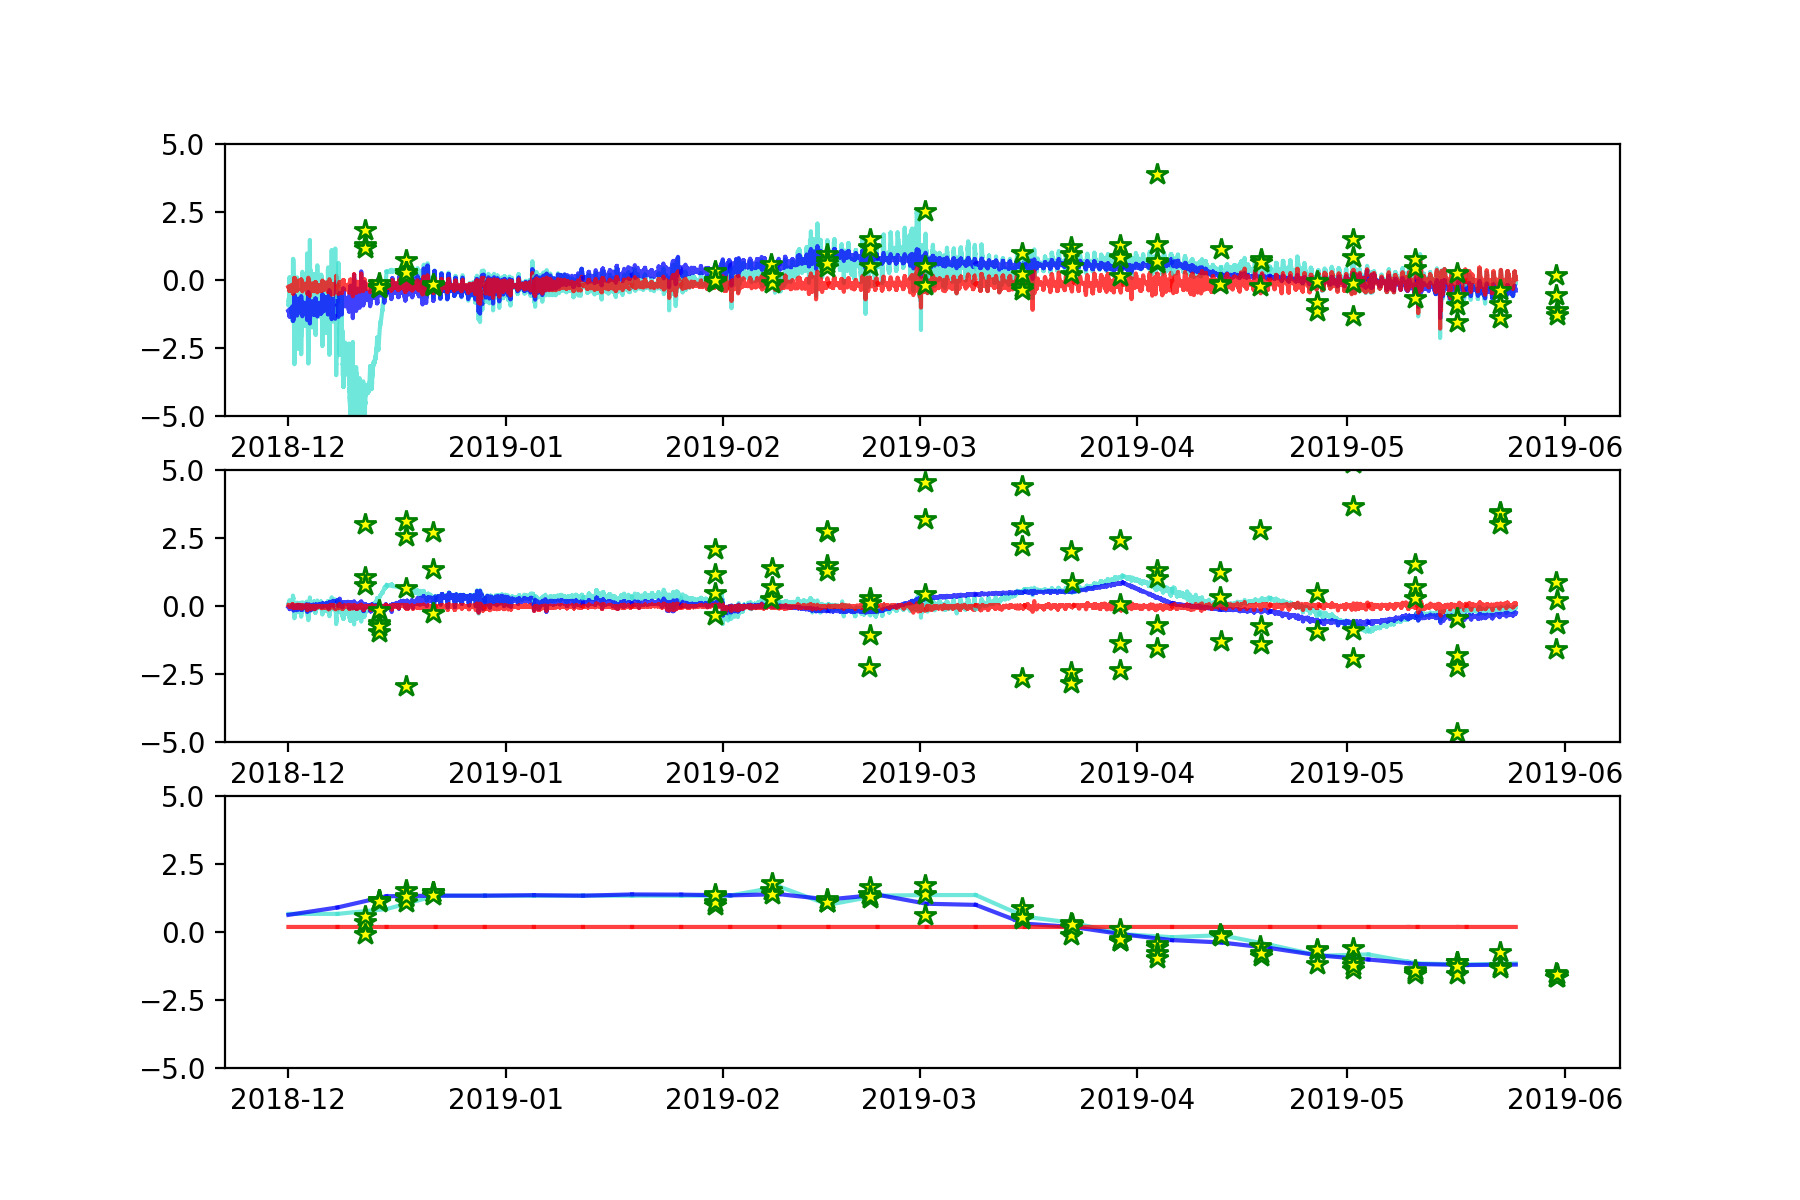

/Users/erigler/anaconda3/envs/test_GIMP_py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [170]:
#
# plot differences between different adjusted (and quasi-definitive)
# and static traditional HDZ baseline-adjusted data
#
plt.figure(figsize=(9,6))
for interval in range(len(utc_xyzf_weekly_007_causal)):

    plt.subplot(3,1,1)
#     plt.plot([utc.datetime for utc in utc_xyzf_weekly_007_causal[interval]], 
#              xyzf_def_weekly_007_causal[interval][0] - 
#              xyzf_trad_weekly_007_causal[interval][0], 'black')
    plt.plot([utc.datetime for utc in utc_xyzf_weekly_007_causal[interval]], 
             xyzf_adj_weekly_007_causal[interval][0] -
             xyzf_trad_weekly_007_causal[interval][0], 'turquoise', alpha=.75)
    plt.plot([utc.datetime for utc in utc_xyzf_weekly_007_acausal[interval]], 
             xyzf_adj_weekly_007_acausal[interval][0] -
             xyzf_trad_weekly_007_acausal[interval][0], 'blue', alpha=.75)
    plt.plot([utc.datetime for utc in utc_xyzf_weekly_007_acausal[interval]], 
             xyzf_adj_weekly_inf_acausal[interval][0] -
             xyzf_trad_weekly_inf_acausal[interval][0], 'red', alpha=.75)
   
    plt.subplot(3,1,2)
#     plt.plot([utc.datetime for utc in utc_xyzf_weekly_007_causal[interval]], 
#              xyzf_def_weekly_007_causal[interval][1] -
#              xyzf_trad_weekly_007_causal[interval][1], 'black')
    plt.plot([utc.datetime for utc in utc_xyzf_weekly_007_causal[interval]], 
             xyzf_adj_weekly_007_causal[interval][1] -
             xyzf_trad_weekly_007_causal[interval][1], 'turquoise', alpha=.75)
    plt.plot([utc.datetime for utc in utc_xyzf_weekly_007_acausal[interval]], 
             xyzf_adj_weekly_007_acausal[interval][1] -
             xyzf_trad_weekly_007_acausal[interval][1], 'blue', alpha=.75)
    plt.plot([utc.datetime for utc in utc_xyzf_weekly_007_acausal[interval]], 
             xyzf_adj_weekly_inf_acausal[interval][1] -
             xyzf_trad_weekly_inf_acausal[interval][1], 'red', alpha=.75)

    plt.subplot(3,1,3)
#     plt.plot([utc.datetime for utc in utc_xyzf_weekly_007_causal[interval]], 
#              xyzf_def_weekly_007_causal[interval][2] -
#              xyzf_trad_weekly_007_causal[interval][2], 'black')
    plt.plot([utc.datetime for utc in utc_xyzf_weekly_007_causal[interval]], 
             xyzf_adj_weekly_007_causal[interval][2] -
             xyzf_trad_weekly_007_causal[interval][2], 'turquoise', alpha=.75)
    plt.plot([utc.datetime for utc in utc_xyzf_weekly_007_acausal[interval]], 
             xyzf_adj_weekly_007_acausal[interval][2] -
             xyzf_trad_weekly_007_acausal[interval][2], 'blue', alpha=.75)
    plt.plot([utc.datetime for utc in utc_xyzf_weekly_007_acausal[interval]], 
             xyzf_adj_weekly_inf_acausal[interval][2] -
             xyzf_trad_weekly_inf_acausal[interval][2], 'red', alpha=.75)


# plot differences between absolutes and static baseline-adjusted data
idx = (utc_bas_all_inf_acausal > start_UTC) & (utc_bas_all_inf_acausal < end_UTC)
plt.subplot(3,1,1)
plt.ylim([-5,5])
plt.plot([utc.datetime for utc in utc_bas_all_inf_acausal[idx]],
         abs_xyz_all_inf_acausal[0][idx] - 
         np.interp(utc_bas_all_inf_acausal[idx].astype(float), 
                   utc_xyzf_all_inf_acausal[0].astype(float), 
                   xyzf_trad_all_inf_acausal[0][0]),
        '*', c='green', mfc='yellow', ms=8)
plt.subplot(3,1,2)
plt.ylim([-5,5])
plt.plot([utc.datetime for utc in utc_bas_all_inf_acausal[idx]],
         abs_xyz_all_inf_acausal[1][idx] - 
         np.interp(utc_bas_all_inf_acausal[idx].astype(float), 
                   utc_xyzf_all_inf_acausal[0].astype(float), 
                   xyzf_trad_all_inf_acausal[0][1]),
        '*', c='green', mfc='yellow', ms=8)
plt.subplot(3,1,3)
plt.ylim([-5,5])
plt.plot([utc.datetime for utc in utc_bas_all_inf_acausal[idx]],
         abs_xyz_all_inf_acausal[2][idx] - 
         np.interp(utc_bas_all_inf_acausal[idx].astype(float), 
                   utc_xyzf_all_inf_acausal[0].astype(float), 
                   xyzf_trad_all_inf_acausal[0][2]),
        '*', c='green', mfc='yellow', ms=8)


<IPython.core.display.Javascript object>


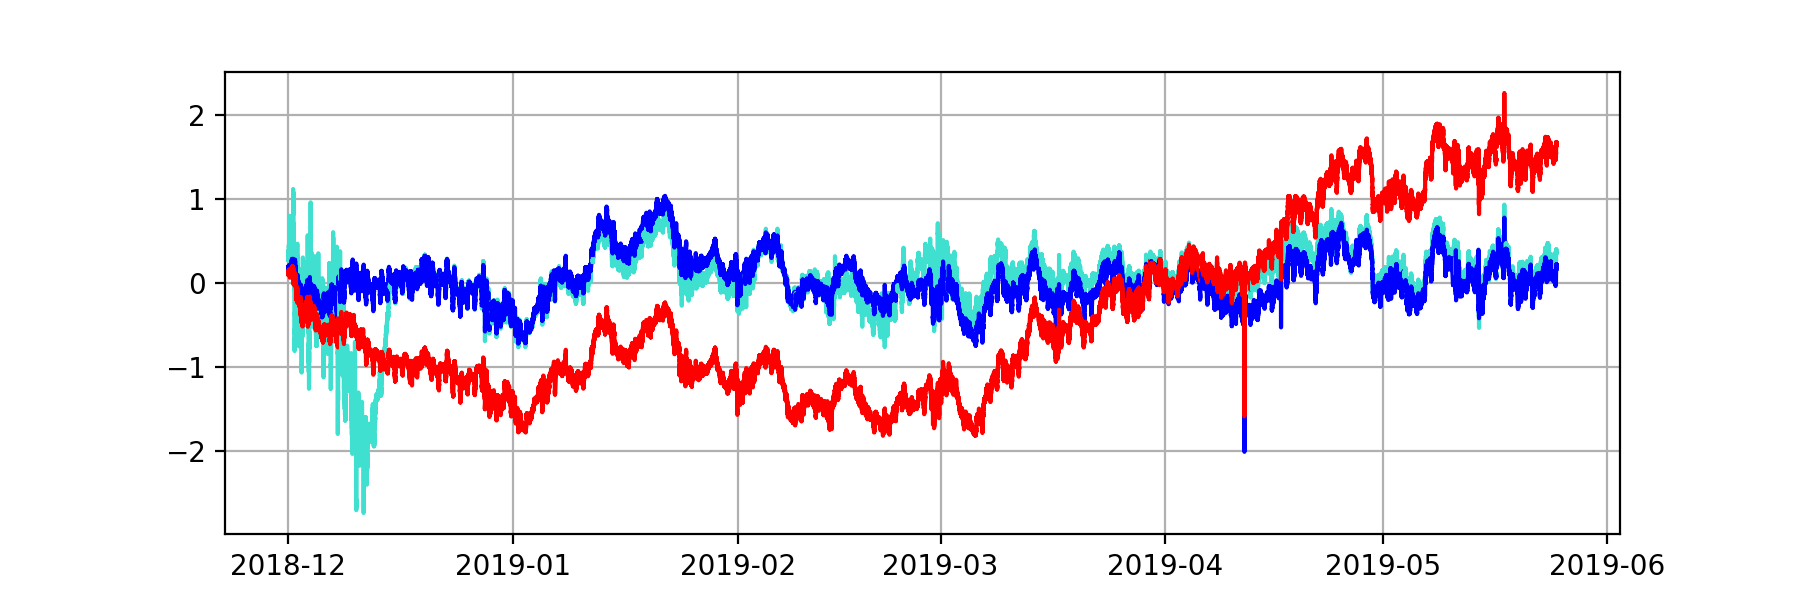

In [171]:
plt.figure(figsize=(9,3))

for interval in range(len(utc_xyzf_weekly_007_causal)):
#     plt.plot([utc.datetime for utc in utc_xyzf_weekly_007_causal[interval]], 
#              np.linalg.norm(xyzf_def_weekly_007_causal[interval][:3], axis=0) - 
#              xyzf_def_weekly_007_causal[interval][3], 'black')
    plt.plot([utc.datetime for utc in utc_xyzf_weekly_007_causal[interval]], 
             np.linalg.norm(xyzf_adj_weekly_007_causal[interval][:3], axis=0) - 
             xyzf_adj_weekly_007_causal[interval][3], 'turquoise')
    plt.plot([utc.datetime for utc in utc_xyzf_weekly_007_acausal[interval]], 
             np.linalg.norm(xyzf_adj_weekly_007_acausal[interval][:3], axis=0) - 
             xyzf_adj_weekly_007_acausal[interval][3], 'blue')
    plt.plot([utc.datetime for utc in utc_xyzf_weekly_inf_acausal[interval]], 
             np.linalg.norm(xyzf_adj_weekly_inf_acausal[interval][:3], axis=0) - 
             xyzf_adj_weekly_inf_acausal[interval][3], 'red')


<IPython.core.display.Javascript object>


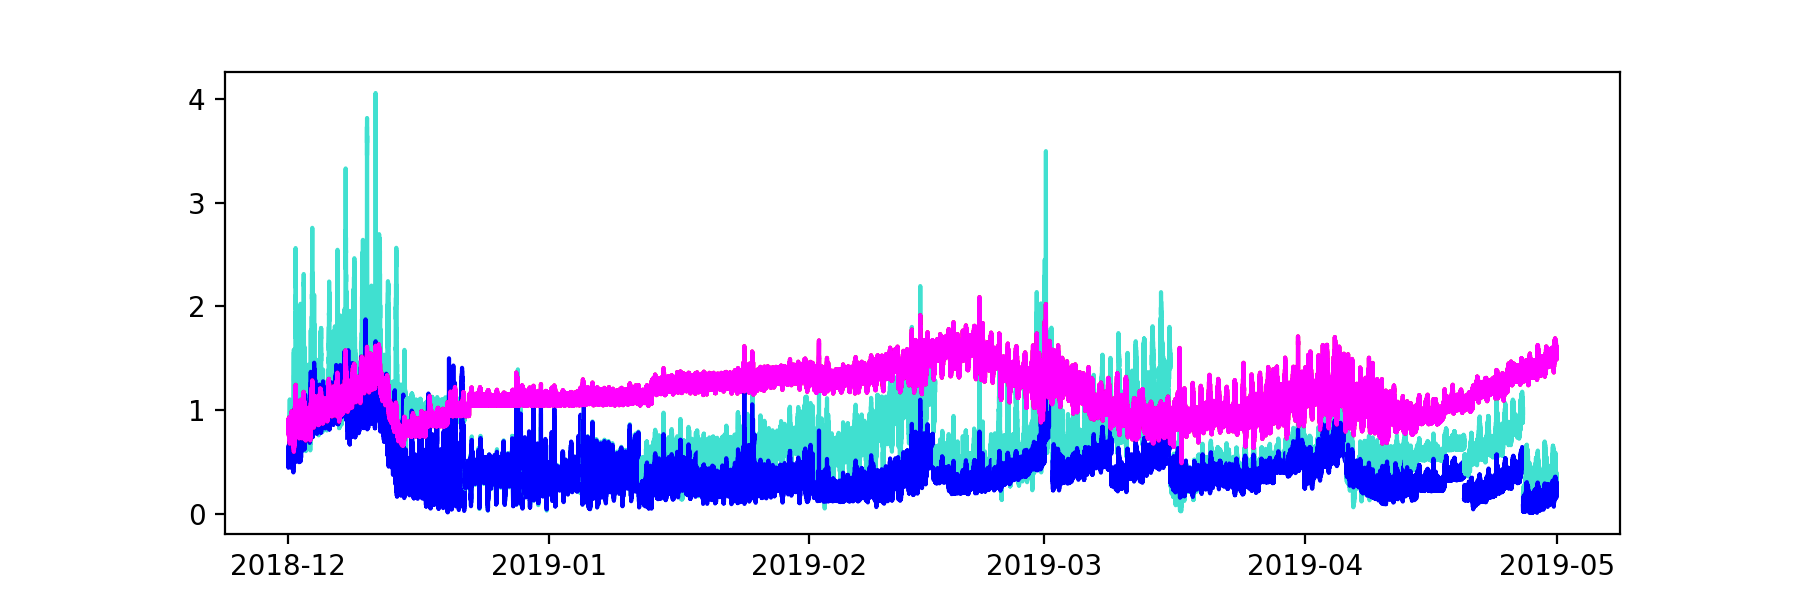

In [370]:
plt.figure(figsize=(9,3))
for interval in range(len(utc_xyzf_weekly_007_acausal)):
    plt.plot([utc.datetime for utc in utc_xyzf_weekly_007_causal[interval]], 
             vector_dist(xyzf_adj_weekly_007_causal[interval][:3], 
                         xyzf_def_weekly_007_causal[interval][:3],
                         'euclidean'), c='turquoise')
    plt.plot([utc.datetime for utc in utc_xyzf_weekly_007_acausal[interval]], 
             vector_dist(xyzf_adj_weekly_007_acausal[interval][:3], 
                         xyzf_def_weekly_007_acausal[interval][:3],
                         'euclidean'), c='blue')
    plt.plot([utc.datetime for utc in utc_xyzf_weekly_inf_acausal[interval]], 
             vector_dist(xyzf_adj_weekly_inf_acausal[interval][:3], 
                         xyzf_def_weekly_inf_acausal[interval][:3],
                         'euclidean'), c='red')

plt.plot([utc.datetime for utc in utc_xyzf_all_inf_acausal[0]],
         vector_dist(xyzf_adj_all_inf_acausal[0][:3],
                     xyzf_def_all_inf_acausal[0][:3],
                     'euclidean'), c='magenta')

In [ ]:
xyz_30_list[0][0].shape

In [ ]:
#
# configuration parameters for BOU
#
start_date = '2018-03-01T00:00:00Z'
end_date = '2018-09-01T00:00:00Z'
obs_code = 'BOU'
validate = True # validate against QD data

#
# Run do_it_all()
#
M0, M1, M2, M3, pc = do_it_all(obs_code, start_date, end_date, validate=validate)

#
# save type 0 matrix to state file
#
import geomagio
from geomagio.algorithm import AdjustedAlgorithm
adjAlg = AdjustedAlgorithm(
    matrix = M0,
    pier_correction = pc.mean(),
    statefile = 'adj' + obs_code + '_state_' + '.json'
)
adjAlg.save_state()

In [ ]:
#
# configuration parameters for BSL
#
start_date = '2018-03-01T00:00:00Z'
end_date = '2018-09-01T00:00:00Z'
obs_code = 'BOU'
validate = True # validate against QD data

#
# Run do_it_all()
#
M0, M1, M2, M3, pc = do_it_all(obs_code, start_date, end_date, validate=validate)

#
# save type 0 matrix to state file
#
import geomagio
from geomagio.algorithm import AdjustedAlgorithm
adjAlg = AdjustedAlgorithm(
    matrix = M0,
    pier_correction = pc.mean(),
    statefile = 'adj' + obs_code + '_state_' + '.json'
)
adjAlg.save_state()

## [Barrow (BRW) Observatory](#Adjusted-Data-Algorithm---Contents:)

[[   0.953   -0.258    0.       0.   ]
 [   0.258    0.953    0.       0.   ]
 [   0.       0.       1.    -138.482]
 [   0.       0.       0.       1.   ]]
[[ 9.564e-01 -2.690e-01  0.000e+00 -3.468e+01]
 [ 2.690e-01  9.564e-01  0.000e+00 -1.031e+02]
 [ 0.000e+00  0.000e+00  1.010e+00 -6.839e+02]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
[[ 9.611e-01 -2.860e-01  1.670e-03 -1.769e+02]
 [ 2.658e-01  9.611e-01 -1.831e-03  3.168e+01]
 [ 1.549e-03  2.803e-02  9.611e-01  2.059e+03]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
[[ 9.463e-01 -2.909e-01  2.291e-02 -1.248e+03]
 [ 2.656e-01  9.592e-01 -2.012e-03  4.351e+01]
 [-2.062e-02  3.236e-02  1.050e+00 -2.752e+03]
 [-0.000e+00 -0.000e+00  0.000e+00  1.000e+00]]


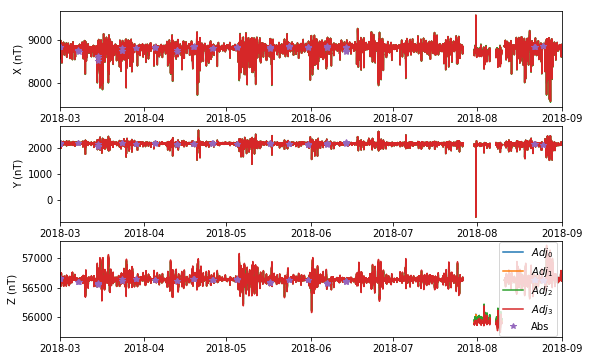

In [102]:
#
# configuration parameters for BRW
#
start_date = '2018-03-01T00:00:00Z'
end_date = '2018-09-01T00:00:00Z'
obs_code = 'BRW'
validate = False # validate against QD data

#
# Run do_it_all()
#
M0, M1, M2, M3, pc = do_it_all(obs_code, start_date, end_date, validate=validate)

#
# save type 0 matrix to state file
#
import geomagio
from geomagio.algorithm import AdjustedAlgorithm
adjAlg = AdjustedAlgorithm(
    matrix = M0,
    pier_correction = pc.mean(),
    statefile = 'adj' + obs_code + '_state_' + '.json'
)
adjAlg.save_state()

## [Stennis (BSL) Observatory](#Adjusted-Data-Algorithm---Contents:)

[[ 1.027e+00  1.268e-02  0.000e+00  0.000e+00]
 [-1.268e-02  1.027e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  1.000e+00  9.470e+01]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
[[ 1.006e+00  2.007e-02  0.000e+00  4.933e+02]
 [-2.007e-02  1.006e+00  0.000e+00  1.682e+02]
 [ 0.000e+00  0.000e+00  8.865e-01  4.722e+03]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
[[ 9.683e-01  1.253e-02  4.848e-02 -6.055e+02]
 [-6.530e-03  9.683e-01 -3.909e-02  1.440e+03]
 [-4.063e-03 -3.342e-02  9.683e-01  1.474e+03]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
[[ 9.938e-01  1.807e-02  4.521e-02 -1.063e+03]
 [ 1.660e-02  1.032e+00 -5.847e-02  1.702e+03]
 [ 1.286e-02 -9.395e-03  8.882e-01  4.348e+03]
 [ 0.000e+00 -0.000e+00  0.000e+00  1.000e+00]]


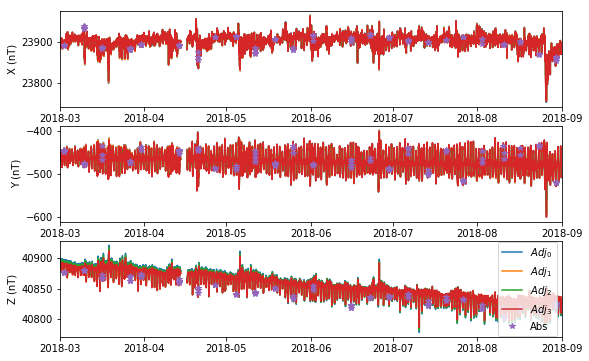

In [103]:
#
# configuration parameters for BSL
#
start_date = '2018-03-01T00:00:00Z'
end_date = '2018-09-01T00:00:00Z'
obs_code = 'BSL'
validate = False # validate against QD data

#
# Run do_it_all()
#
M0, M1, M2, M3, pc = do_it_all(obs_code, start_date, end_date, validate=validate)

#
# save type 0 matrix to state file
#
import geomagio
from geomagio.algorithm import AdjustedAlgorithm
adjAlg = AdjustedAlgorithm(
    matrix = M0,
    pier_correction = pc.mean(),
    statefile = 'adj' + obs_code + '_state_' + '.json'
)
adjAlg.save_state()

## [College (CMO) Observatory](#Adjusted-Data-Algorithm---Contents:)

[[  0.96   -0.326   0.      0.   ]
 [  0.326   0.96    0.      0.   ]
 [  0.      0.      1.    -57.574]
 [  0.      0.      0.      1.   ]]
[[ 9.596e-01 -3.294e-01  0.000e+00  4.678e+00]
 [ 3.294e-01  9.596e-01  0.000e+00 -4.416e+01]
 [ 0.000e+00  0.000e+00  1.025e+00 -1.426e+03]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
[[ 9.970e-01 -3.495e-01 -3.531e-02  1.486e+03]
 [ 2.957e-01  9.970e-01  3.063e-02 -1.307e+03]
 [ 9.227e-03  1.401e-02  9.970e-01 -4.730e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
[[ 9.512e-01 -3.564e-01 -8.754e-03  5.854e+02]
 [ 2.907e-01  9.725e-01  3.049e-02 -1.245e+03]
 [-3.643e-02  1.433e-02  1.048e+00 -2.274e+03]
 [-0.000e+00  0.000e+00 -0.000e+00  1.000e+00]]


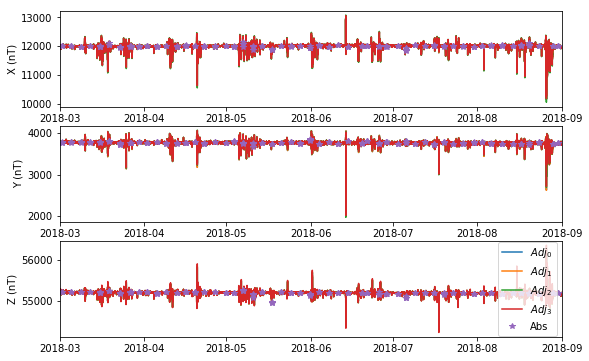

In [104]:
#
# configuration parameters for CMO
#
start_date = '2018-03-01T00:00:00Z'
end_date = '2018-09-01T00:00:00Z'
obs_code = 'CMO'
validate = False # validate against QD data

#
# Run do_it_all()
#
M0, M1, M2, M3, pc = do_it_all(obs_code, start_date, end_date, validate=validate)

#
# save type 0 matrix to state file
#
import geomagio
from geomagio.algorithm import AdjustedAlgorithm
adjAlg = AdjustedAlgorithm(
    matrix = M0,
    pier_correction = pc.mean(),
    statefile = 'adj' + obs_code + '_state_' + '.json'
)
adjAlg.save_state()

## [Deadhorse (DED) Observatory](#Adjusted-Data-Algorithm---Contents:)

[[ 0.919 -0.355  0.     0.   ]
 [ 0.355  0.919  0.     0.   ]
 [ 0.     0.     1.    22.798]
 [ 0.     0.     0.     1.   ]]
[[   0.915   -0.365    0.      31.443]
 [   0.365    0.915    0.     -96.716]
 [   0.       0.       1.005 -242.835]
 [   0.       0.       0.       1.   ]]
[[ 9.385e-01 -3.521e-01  7.930e-03 -6.235e+02]
 [ 3.762e-01  9.385e-01  8.013e-03 -6.399e+02]
 [-8.826e-03  6.592e-04  9.385e-01  3.586e+03]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
[[ 9.218e-01 -3.630e-01  3.892e-03 -2.486e+02]
 [ 3.587e-01  9.029e-01  8.678e-03 -5.393e+02]
 [ 1.709e-03 -4.195e-04  1.005e+00 -2.993e+02]
 [ 0.000e+00  0.000e+00 -0.000e+00  1.000e+00]]


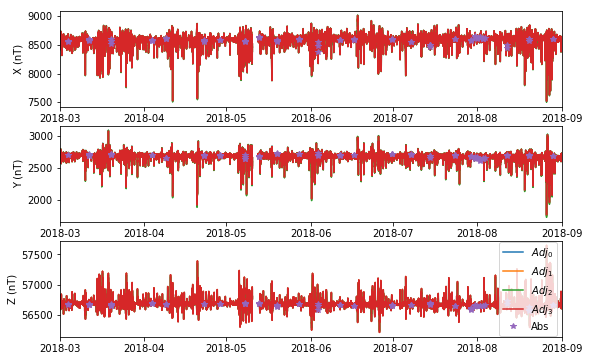

In [105]:
#
# configuration parameters for DED
#
start_date = '2018-03-01T00:00:00Z'
end_date = '2018-09-01T00:00:00Z'
obs_code = 'DED'
validate = False # validate against QD data

#
# Run do_it_all()
#
M0, M1, M2, M3, pc = do_it_all(obs_code, start_date, end_date, validate=validate)

#
# save type 0 matrix to state file
#
import geomagio
from geomagio.algorithm import AdjustedAlgorithm
adjAlg = AdjustedAlgorithm(
    matrix = M0,
    pier_correction = pc.mean(),
    statefile = 'adj' + obs_code + '_state_' + '.json'
)
adjAlg.save_state()

## [Fredericksburgh (FRD) Observatory](#Adjusted-Data-Algorithm---Contents:)

[[ 9.785e-01  1.822e-01  0.000e+00  0.000e+00]
 [-1.822e-01  9.785e-01  0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  1.000e+00  7.087e+02]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
[[ 1.044e+00  1.641e-01  0.000e+00 -1.408e+03]
 [-1.641e-01  1.044e+00  0.000e+00 -3.916e+02]
 [ 0.000e+00  0.000e+00  1.117e+00 -4.638e+03]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
[[ 1.006e+00  1.617e-01  3.380e-03 -7.428e+02]
 [-2.269e-01  1.006e+00 -1.492e-01  7.756e+03]
 [ 7.804e-03 -8.029e-02  1.006e+00  2.759e+02]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
[[ 9.642e-01  1.658e-01  2.112e-03  2.130e+02]
 [-2.168e-01  9.504e-01 -1.926e-01  9.512e+03]
 [ 1.226e-02 -1.969e-02  1.103e+00 -4.244e+03]
 [-0.000e+00 -0.000e+00 -0.000e+00  1.000e+00]]


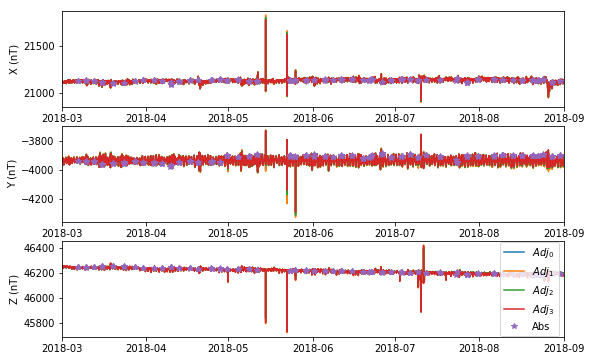

In [106]:
#
# configuration parameters for FRD
#
start_date = '2018-03-01T00:00:00Z'
end_date = '2018-09-01T00:00:00Z'
obs_code = 'FRD'
validate = False # validate against QD data

#
# Run do_it_all()
#
M0, M1, M2, M3, pc = do_it_all(obs_code, start_date, end_date, validate=validate)

#
# save type 0 matrix to state file
#
import geomagio
from geomagio.algorithm import AdjustedAlgorithm
adjAlg = AdjustedAlgorithm(
    matrix = M0,
    pier_correction = pc.mean(),
    statefile = 'adj' + obs_code + '_state_' + '.json'
)
adjAlg.save_state()

## [Fresno (FRN) Observatory](#Adjusted-Data-Algorithm---Contents:)

[[ 0.965 -0.22   0.     0.   ]
 [ 0.22   0.965  0.     0.   ]
 [ 0.     0.     1.    67.484]
 [ 0.     0.     0.     1.   ]]
[[ 9.408e-01 -1.886e-01  0.000e+00  5.645e+02]
 [ 1.886e-01  9.408e-01  0.000e+00  7.482e+02]
 [ 0.000e+00  0.000e+00  1.006e+00 -1.822e+02]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
[[ 9.869e-01 -2.097e-01  3.919e-02 -2.164e+03]
 [ 2.192e-01  9.869e-01 -2.772e-01  1.167e+04]
 [ 2.441e-02  1.699e-02  9.869e-01  4.362e+01]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
[[ 9.863e-01 -2.097e-01  3.932e-02 -2.155e+03]
 [ 2.187e-01  9.819e-01 -2.749e-01  1.158e+04]
 [ 2.281e-02  1.457e-02  9.959e-01 -2.955e+02]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]


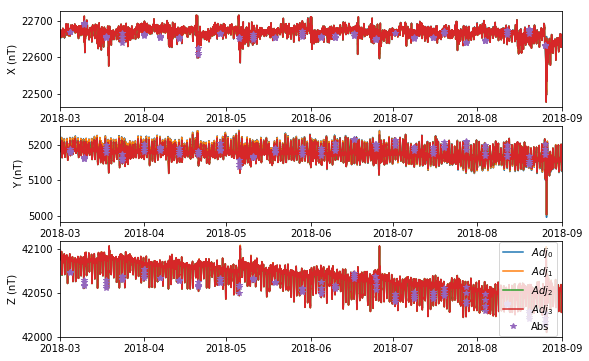

In [107]:
#
# configuration parameters for FRN
#
start_date = '2018-03-01T00:00:00Z'
end_date = '2018-09-01T00:00:00Z'
obs_code = 'FRN'
validate = False # validate against QD data

#
# Run do_it_all()
#
M0, M1, M2, M3, pc = do_it_all(obs_code, start_date, end_date, validate=validate)

#
# save type 0 matrix to state file
#
import geomagio
from geomagio.algorithm import AdjustedAlgorithm
adjAlg = AdjustedAlgorithm(
    matrix = M0,
    pier_correction = pc.mean(),
    statefile = 'adj' + obs_code + '_state_' + '.json'
)
adjAlg.save_state()

## [Guam (GUA) Observatory](#Adjusted-Data-Algorithm---Contents:)

[[ 1.016e+00 -1.991e-02  0.000e+00  0.000e+00]
 [ 1.991e-02  1.016e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  1.000e+00  2.546e+02]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
[[ 1.014e+00 -1.241e-02  0.000e+00  6.956e+01]
 [ 1.241e-02  1.014e+00  0.000e+00  2.643e+02]
 [ 0.000e+00  0.000e+00  1.002e+00  2.396e+02]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
[[ 1.014e+00 -1.094e-02  6.216e-03  1.006e+01]
 [ 1.323e-02  1.014e+00 -1.077e-04  2.364e+02]
 [ 6.604e-03  1.718e-03  1.014e+00 -8.888e+01]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
[[ 9.986e-01 -1.997e-02 -7.584e-03  6.747e+02]
 [ 2.301e-02  1.042e+00  8.549e-03 -1.704e+02]
 [ 5.469e-03  1.060e-03  1.007e+00  1.046e+01]
 [ 0.000e+00 -0.000e+00  0.000e+00  1.000e+00]]


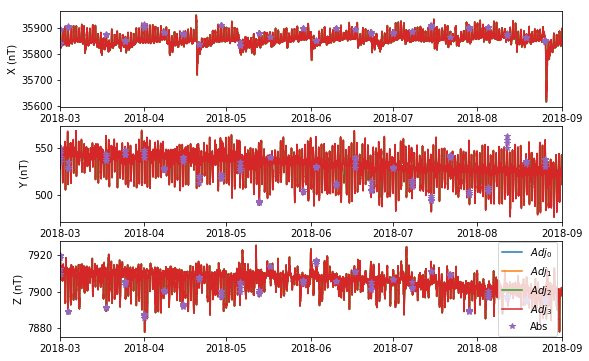

In [108]:
#
# configuration parameters for GUA
#
start_date = '2018-03-01T00:00:00Z'
end_date = '2018-09-01T00:00:00Z'
obs_code = 'GUA'
validate = False # validate against QD data

#
# Run do_it_all()
#
M0, M1, M2, M3, pc = do_it_all(obs_code, start_date, end_date, validate=validate)

#
# save type 0 matrix to state file
#
import geomagio
from geomagio.algorithm import AdjustedAlgorithm
adjAlg = AdjustedAlgorithm(
    matrix = M0,
    pier_correction = pc.mean(),
    statefile = 'adj' + obs_code + '_state_' + '.json'
)
adjAlg.save_state()

## [Honolulu (HON) Observatory](#Adjusted-Data-Algorithm---Contents:)

[[  0.984  -0.172   0.      0.   ]
 [  0.172   0.984   0.      0.   ]
 [  0.      0.      1.    126.704]
 [  0.      0.      0.      1.   ]]
[[ 9.788e-01 -1.868e-01  0.000e+00  1.451e+02]
 [ 1.868e-01  9.788e-01  0.000e+00 -4.136e+02]
 [ 0.000e+00  0.000e+00  9.885e-01  3.686e+02]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
[[ 9.774e-01 -1.942e-01 -1.865e-02  5.747e+02]
 [ 1.812e-01  9.774e-01 -1.553e-03 -2.277e+02]
 [-1.599e-02 -1.161e-02  9.774e-01  1.039e+03]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
[[ 9.650e-01 -1.889e-01 -3.199e-02  1.194e+03]
 [ 1.759e-01  9.978e-01 -1.360e-02  1.705e+02]
 [-1.586e-02 -1.173e-02  9.779e-01  1.024e+03]
 [ 0.000e+00 -0.000e+00  0.000e+00  1.000e+00]]


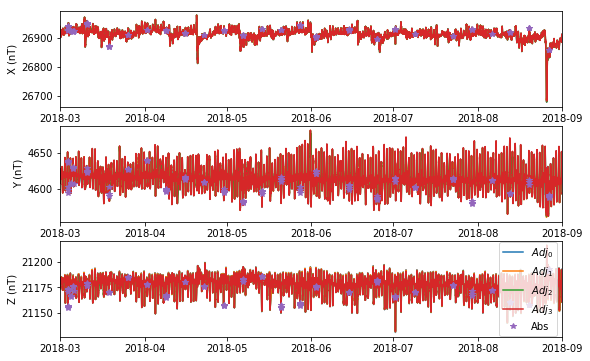

In [109]:
#
# configuration parameters for HON
#
start_date = '2018-03-01T00:00:00Z'
end_date = '2018-09-01T00:00:00Z'
obs_code = 'HON'
validate = False # validate against QD data

#
# Run do_it_all()
#
M0, M1, M2, M3, pc = do_it_all(obs_code, start_date, end_date, validate=validate)

#
# save type 0 matrix to state file
#
import geomagio
from geomagio.algorithm import AdjustedAlgorithm
adjAlg = AdjustedAlgorithm(
    matrix = M0,
    pier_correction = pc.mean(),
    statefile = 'adj' + obs_code + '_state_' + '.json'
)
adjAlg.save_state()

## [Newport (NEW) Observatory](#Adjusted-Data-Algorithm---Contents:)

[[ 9.721e-01 -2.663e-01  0.000e+00  0.000e+00]
 [ 2.663e-01  9.721e-01  0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  1.000e+00  7.207e+02]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
[[ 9.700e-01 -2.408e-01  0.000e+00  3.933e+01]
 [ 2.408e-01  9.700e-01  0.000e+00  4.574e+02]
 [ 0.000e+00  0.000e+00  1.123e+00 -5.502e+03]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
[[ 1.014e+00 -2.590e-01 -3.328e-02  9.257e+02]
 [ 2.330e-01  1.014e+00  8.769e-02 -3.834e+03]
 [-2.713e-02 -2.756e-02  1.014e+00  4.784e+02]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
[[ 9.718e-01 -2.582e-01 -4.197e-02  2.130e+03]
 [ 2.345e-01  9.673e-01  8.515e-02 -3.738e+03]
 [-5.235e-04 -2.378e-02  1.121e+00 -5.417e+03]
 [ 0.000e+00 -0.000e+00 -0.000e+00  1.000e+00]]


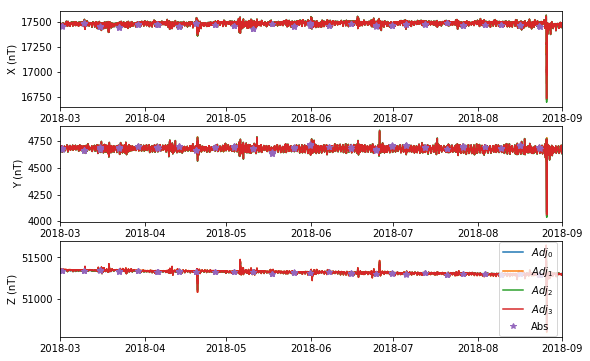

In [110]:
#
# configuration parameters for NEW
#
start_date = '2018-03-01T00:00:00Z'
end_date = '2018-09-01T00:00:00Z'
obs_code = 'NEW'
validate = False # validate against QD data

#
# Run do_it_all()
#
M0, M1, M2, M3, pc = do_it_all(obs_code, start_date, end_date, validate=validate)

#
# save type 0 matrix to state file
#
import geomagio
from geomagio.algorithm import AdjustedAlgorithm
adjAlg = AdjustedAlgorithm(
    matrix = M0,
    pier_correction = pc.mean(),
    statefile = 'adj' + obs_code + '_state_' + '.json'
)
adjAlg.save_state()

## [San Juan (SJG) Observatory](#Adjusted-Data-Algorithm---Contents:)

[[ 9.793e-01  2.221e-01  0.000e+00  0.000e+00]
 [-2.221e-01  9.793e-01  0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  1.000e+00  2.738e+02]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
[[ 9.546e-01 -1.800e-01  0.000e+00  6.194e+02]
 [ 1.800e-01  9.546e-01  0.000e+00 -1.083e+04]
 [ 0.000e+00  0.000e+00  1.085e+00 -1.845e+03]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
[[ 1.069e+00  2.643e-01 -1.131e-01  3.983e+02]
 [-3.623e-01  1.069e+00 -7.689e-01  2.285e+04]
 [ 1.750e-02  1.077e-01  1.069e+00 -1.892e+03]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
[[ 9.394e-01  2.398e-01 -1.682e-01  5.247e+03]
 [-3.408e-01  1.275e+00 -7.971e-01  2.300e+04]
 [ 2.411e-02  1.038e-01  1.077e+00 -2.282e+03]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]


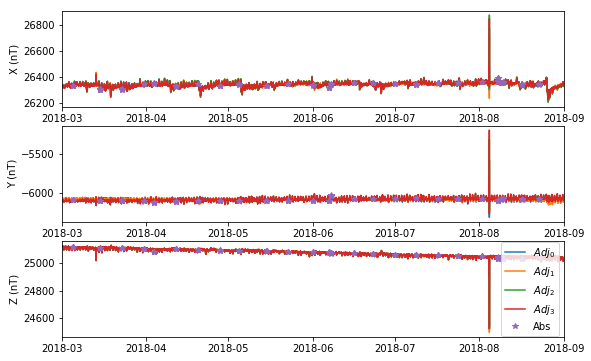

In [113]:
#
# configuration parameters for SJG
#
start_date = '2018-03-01T00:00:00Z'
end_date = '2018-09-01T00:00:00Z'
obs_code = 'SJG'
validate = False # validate against QD data

#
# Run do_it_all()
#
M0, M1, M2, M3, pc = do_it_all(obs_code, start_date, end_date, validate=validate)

#
# save type 0 matrix to state file
#
import geomagio
from geomagio.algorithm import AdjustedAlgorithm
adjAlg = AdjustedAlgorithm(
    matrix = M0,
    pier_correction = pc.mean(),
    statefile = 'adj' + obs_code + '_state_' + '.json'
)
adjAlg.save_state()

## [Shumagin (SHU) Observatory](#Adjusted-Data-Algorithm---Contents:)

[[ 9.720e-01 -1.919e-01  0.000e+00  0.000e+00]
 [ 1.919e-01  9.720e-01  0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  1.000e+00 -3.212e+02]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
[[ 1.018e+00 -1.868e-01  0.000e+00 -9.111e+02]
 [ 1.868e-01  1.018e+00  0.000e+00  1.102e+02]
 [ 0.000e+00  0.000e+00  1.127e+00 -6.488e+03]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
[[ 1.015e+00 -1.951e-01  1.547e-02 -1.617e+03]
 [ 1.461e-01  1.015e+00  9.451e-02 -3.671e+03]
 [ 3.074e-02  3.505e-02  1.015e+00 -1.674e+03]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
[[ 1.025e+00 -1.969e-01  1.167e-02 -1.624e+03]
 [ 1.552e-01  9.891e-01  1.208e-01 -5.137e+03]
 [ 1.607e-02  1.415e-02  1.099e+00 -5.467e+03]
 [ 0.000e+00 -0.000e+00 -0.000e+00  1.000e+00]]


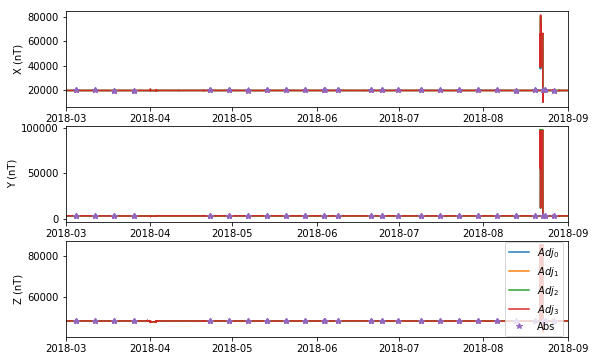

In [111]:
#
# configuration parameters for SHU
#
start_date = '2018-03-01T00:00:00Z'
end_date = '2018-09-01T00:00:00Z'
obs_code = 'SHU'
validate = False # validate against QD data

#
# Run do_it_all()
#
M0, M1, M2, M3, pc = do_it_all(obs_code, start_date, end_date, validate=validate)

#
# save type 0 matrix to state file
#
import geomagio
from geomagio.algorithm import AdjustedAlgorithm
adjAlg = AdjustedAlgorithm(
    matrix = M0,
    pier_correction = pc.mean(),
    statefile = 'adj' + obs_code + '_state_' + '.json'
)
adjAlg.save_state()

## [Sitka (SIT) Observatory](#Adjusted-Data-Algorithm---Contents:)

Magnetometer altered, discarding measurements prior to 2018-07-11 20:40:00
[[ 0.95  -0.325  0.     0.   ]
 [ 0.325  0.95   0.     0.   ]
 [ 0.     0.     1.    72.418]
 [ 0.     0.     0.     1.   ]]
[[ 9.387e-01 -3.454e-01  0.000e+00  1.788e+02]
 [ 3.454e-01  9.387e-01  0.000e+00 -3.249e+02]
 [ 0.000e+00  0.000e+00  9.845e-01  8.970e+02]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
[[ 9.480e-01 -3.502e-01 -1.832e-02  1.005e+03]
 [ 3.401e-01  9.480e-01  2.784e-02 -1.718e+03]
 [ 2.619e-02 -1.562e-02  9.480e-01  2.418e+03]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
[[ 9.351e-01 -3.416e-01 -5.063e-03  5.054e+02]
 [ 3.414e-01  9.468e-01  2.617e-02 -1.649e+03]
 [ 1.103e-02 -2.313e-03  9.783e-01  1.048e+03]
 [-0.000e+00  0.000e+00  0.000e+00  1.000e+00]]


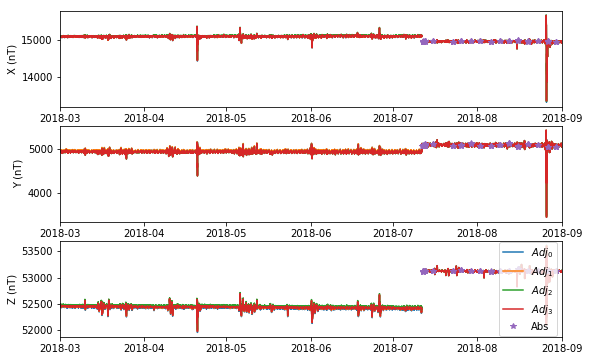

In [112]:
#
# configuration parameters for SIT
#
start_date = '2018-03-01T00:00:00Z'
end_date = '2018-09-01T00:00:00Z'
obs_code = 'SIT'
validate = False # validate against QD data

#
# Run do_it_all()
#
M0, M1, M2, M3, pc = do_it_all(obs_code, start_date, end_date, validate=validate)

#
# save type 0 matrix to state file
#
import geomagio
from geomagio.algorithm import AdjustedAlgorithm
adjAlg = AdjustedAlgorithm(
    matrix = M0,
    pier_correction = pc.mean(),
    statefile = 'adj' + obs_code + '_state_' + '.json'
)
adjAlg.save_state()

## [Tucson (TUC) Observatory](#Adjusted-Data-Algorithm---Contents:)

[[ 9.770e-01 -1.619e-01  0.000e+00  0.000e+00]
 [ 1.619e-01  9.770e-01  0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  1.000e+00  3.476e+02]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
[[ 1.006e+00 -1.654e-01  0.000e+00 -7.028e+02]
 [ 1.654e-01  1.006e+00  0.000e+00 -8.159e+01]
 [ 0.000e+00  0.000e+00  9.449e-01  2.559e+03]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
[[ 9.646e-01 -2.046e-01  1.408e-01 -5.351e+03]
 [ 1.704e-01  9.646e-01  1.626e-01 -6.730e+03]
 [ 2.146e-02 -2.987e-03  9.646e-01  1.240e+03]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
[[ 9.841e-01 -2.074e-01  1.418e-01 -5.866e+03]
 [ 1.705e-01  9.642e-01  1.629e-01 -6.746e+03]
 [ 2.056e-02  5.086e-03  9.400e-01  2.250e+03]
 [-0.000e+00  0.000e+00 -0.000e+00  1.000e+00]]


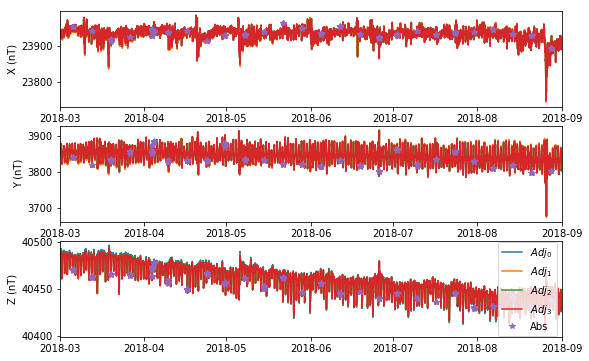

In [114]:
#
# configuration parameters for TUC
#
start_date = '2018-03-01T00:00:00Z'
end_date = '2018-09-01T00:00:00Z'
obs_code = 'TUC'
validate = False # validate against QD data

#
# Run do_it_all()
#
M0, M1, M2, M3, pc = do_it_all(obs_code, start_date, end_date, validate=validate)

#
# save type 0 matrix to state file
#
import geomagio
from geomagio.algorithm import AdjustedAlgorithm
adjAlg = AdjustedAlgorithm(
    matrix = M0,
    pier_correction = pc.mean(),
    statefile = 'adj' + obs_code + '_state_' + '.json'
)
adjAlg.save_state()